In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from gadget import gadget_readsnap
from gadget_subfind import load_subfind

ELEMENTS = { 'H':0, 'He':1, 'C':2, 'N':3, 'O':4,
            'Ne':5, 'Mg':6, 'Si':7, 'Fe':8 }

# from Asplund et al. (2009) Table 5
SUNABUNDANCES = { 'H':12.0, 'He':10.98, 'C':8.47, 'N':7.87, 'O':8.73,
                  'Ne':7.97, 'Mg':7.64, 'Si':7.55, 'Fe':7.54 }

In [3]:
def p2(a):
    return ((a)*(a))

In [4]:
def eat_snap_and_fof(level, halo_number, snapnr, snappath, loadonlytype=[4],
                     haloid=0, galradfac=0.1, verbose=True):
    """ Method to eat an Auriga snapshot, given a level/halo_number/snapnr.
        Subfind has been executed 'on-the-fly', during the simulation run.

        @param level: level of the Auriga simulation (3=high, 4='normal' or 5=low).
            Level 3/5 only for halo 6, 16 and 24. See Grand+ 2017 for details.
            Careful when level != 4 because directories may have different names.
        @param halo_number: which Auriga galaxy? See Grand+ 2017 for details.
            Should be an integer in range(1, 31)
        @param snapnr: which snapshot number? This is an integer, in most cases
            in range(1, 128) depending on the number of timesteps of the run.
            The last snapshot would then be 127. Snapshots are written at a
            certain time, but careful because the variable called time is actually
            the cosmological expansion factor a = 1/(1+z). For example, snapnr=127
            has s.time = 1, which corresponds to a redshift of ~0. This makes sense
            because this is the last snapshot and the last snapshot is written at
            redshift zero
        @param snappath: full path to the level/halo directory that contains
            all of the simulation snapshots
        @param loadonlytype: which particle types should be loaded? This should
            be a list of integers. If I'm not mistaken, the options are:
            0 (gas), 1 (halo), 2 (disk), 3 (bulge), 4 (stars), 5 (black holes).
            So to get the dark matter: load particles 1/2/3. In zoom-simulations
            particletype 3 may be used for low-resolution particles in the outer
            regions and they should not be present in (and contaminating) the
            inner region. I'm not too sure of the latter though.
        @param haloid: the ID of the SubFind halo. In case you are interested
            in the main galaxy in the simulation run: set haloid to zero.
            This was a bit confusing to me at first because a zoom-simulation run
            of one Auriga galaxy is also referred to as 'halo', see halo_number.
        @param galradfac: the radius of the galaxy is often used to make cuts in
            the (star) particles. It seems that in general galrad is set to 10%
            of the virial radius R200 of the DM halo that the galaxy sits in. The
            disk does seem to 'end' at 0.1R200.
        @param verbose: boolean to print some information

        @return: two-tuple (s, sf) where s is an instance of the gadget_snapshot
            class, and sf is an instance of the subfind class. See Arepo-snap-util,
            gadget_snap.py respectively gadget_subfind.py """

    # Eat the subfind friend of friends output
    sf = load_subfind(snapnr, dir=snappath)

    # Eat the Gadget snapshot
    s = gadget_readsnap(snapnr, snappath=snappath, lazy_load=True,
        subfind=sf, loadonlytype=loadonlytype)
    s.subfind = sf

    # Sets s.(sub)halo. This allows selecting the halo, e.g. 0 (main 'Galaxy')
    s.calc_sf_indizes(s.subfind)
    # Note that selecting the halo now rotates the disk using the principal axis.
    # rotate_disk is a general switch which has to be set to True to rotate.
    # To then actually do the rotation, do_rotation has to be True as well.
    # Within rotate_disk there are three methods to handle the rotation. Choose
    # one of them, but see the select_halo method for details.
    s.select_halo( s.subfind, haloid=haloid, galradfac=galradfac,
        rotate_disk=True, use_principal_axis=True, euler_rotation=False,
        use_cold_gas_spin=False, do_rotation=True )

    # Sneak some more info into the s instance
    s.halo_number = halo_number
    s.level = level
    s.snapnr = snapnr
    s.haloid = haloid

    # This means that galrad is 10 % of R200 (200*rho_crit definition)
    s.galrad = galradfac * sf.data['frc2'][haloid]  # frc2 = Group_R_Crit200

    if verbose:
        print("\ngalrad  : {0}".format(s.galrad))
        print("redshift: {0}".format(s.redshift))
        print("time    : {0}".format(s.time))
        print("center  : {0}\n".format(s.center))

    return s, sf


In [5]:
def get_cartesian_vectors(s, sf, mask):
    x,  y,  z  = s.pos[::,2][mask], s.pos[::,1][mask], s.pos[::,0][mask]
    vx, vy, vz = s.vel[::,2][mask], s.vel[::,1][mask], s.vel[::,0][mask]

    # All three expressions for rxyz compute the same thing :-).
    # rxyz = numpy.sqrt( x**2 + y**2 + z**2)
    # rxyz = numpy.sqrt( (s.pos[mask]**2).sum(axis=1) )
    rxyz = s.r()[mask]

    # Both expressions for rxy compute the same thing :-).
    # rxy = numpy.sqrt( (s.pos[mask][:,1:]**2).sum(axis=1) )
    rxy = numpy.sqrt( x**2 + y**2 )

    return (x, y, z), (vx, vy, vz), rxyz, rxy


In [6]:
level = 4
basedir = "/hits/universe/GigaGalaxy/level{0}_MHD/".format(level)
for halo_number in [24]:  # range(1, 31):
    halodir = basedir+"halo_{0}/".format(halo_number)
    snappath = halodir+"output/"
    for snapnr in range(127, 128, 1):
        print("level   : {0}".format(level))
        print("halo    : {0}".format(halo_number))
        print("snapnr  : {0}".format(snapnr))
        print("basedir : {0}".format(basedir))
        print("halodir : {0}".format(halodir))
        print("snappath: {0}\n".format(snappath))

        s, sf = eat_snap_and_fof(level, halo_number, snapnr, snappath,
            loadonlytype=[1,2,3,4], haloid=0, galradfac=0.1, verbose=True)

        # Clean negative and zero values of gmet to avoid RuntimeErrors
        # later on (e.g. dividing by zero)
        s.data['gmet'] = numpy.maximum( s.data['gmet'], 1e-40 )

level   : 4
halo    : 24
snapnr  : 127
basedir : /hits/universe/GigaGalaxy/level4_MHD/
halodir : /hits/universe/GigaGalaxy/level4_MHD/halo_24/
snappath: /hits/universe/GigaGalaxy/level4_MHD/halo_24/output/

[ 34.42281723  33.16259384  37.29567337]
Found 1783163 stars.
Rotated pos.
Rotated vel.

galrad  : 0.02408556640148163
redshift: 2.220446049250313e-16
time    : 0.9999999999999998
center  : [ 0.  0.  0.]



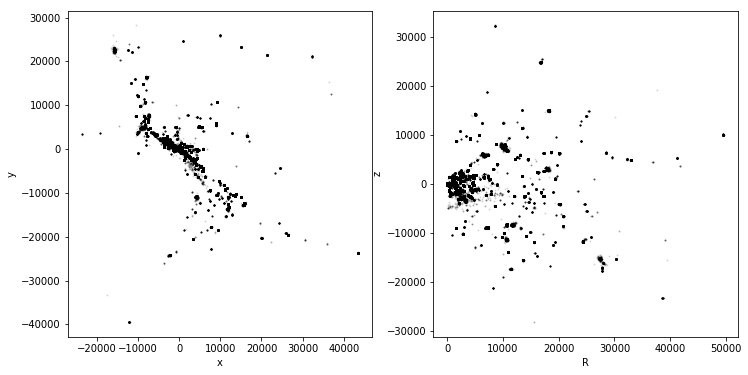

In [7]:
istars, = numpy.where( (s.type == 4) )
(x, y, z), (vx, vy, vz), rxyz, rxy = get_cartesian_vectors(s, sf, istars)

fig, (ax1, ax2) = pyplot.subplots(1, 2, figsize=(12, 6))
ax1.plot(1000*x, 1000*y, "kD", ms=1, alpha=0.1)
ax1.set_xlabel("x")
ax1.set_ylabel("y")

ax2.plot(1000*rxy, 1000*z, "kD", ms=1, alpha=0.1)
ax2.set_xlabel("R")
ax2.set_ylabel("z")

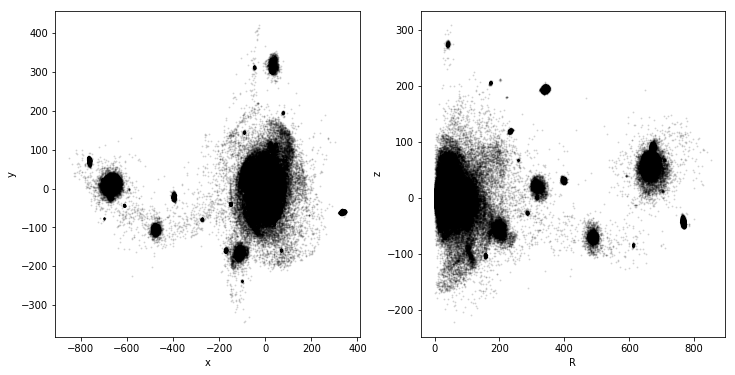

In [8]:
istars, = numpy.where( (s.type == 4) & (s.halo == 0) )
(x, y, z), (vx, vy, vz), rxyz, rxy = get_cartesian_vectors(s, sf, istars)

fig, (ax1, ax2) = pyplot.subplots(1, 2, figsize=(12, 6))

ax1.plot(1000*x, 1000*y, "kD", ms=1, alpha=0.1)
ax1.set_xlabel("x")
ax1.set_ylabel("y")

ax2.plot(1000*rxy, 1000*z, "kD", ms=1, alpha=0.1)
ax2.set_xlabel("R")
ax2.set_ylabel("z")

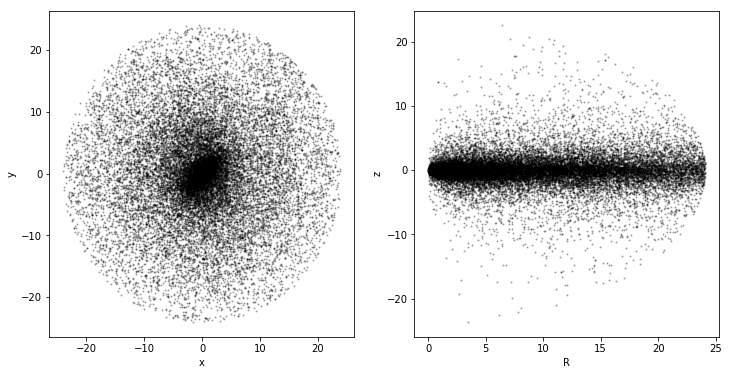

In [9]:
istars, = numpy.where( (s.type == 4) & (s.halo == 0) & (s.r() > 0.) & (s.r() < s.galrad) )
(x, y, z), (vx, vy, vz), rxyz, rxy = get_cartesian_vectors(s, sf, istars)

mask = numpy.random.randint(0, len(x), 32384)

fig, (ax1, ax2) = pyplot.subplots(1, 2, figsize=(12, 6))
ax1.plot(1000*x[mask], 1000*y[mask], "kD", ms=1, alpha=0.25)
ax1.set_xlabel("x")
ax1.set_ylabel("y")

ax2.plot(1000*rxy[mask], 1000*z[mask], "kD", ms=1, alpha=0.25)
ax2.set_xlabel("R")
ax2.set_ylabel("z")

In [10]:
def compute_iron_over_hydrogen_abundance(s, sf, mask):
    metal = numpy.zeros( [numpy.size(mask),2] )
    st = s.nparticlesall[:4].sum()
    en = st + s.nparticlesall[4]
    gmet = numpy.zeros((s.npartall, 9))
    gmet[st:en] = s.data['gmet']
    metal[:, 0] = gmet[mask][:, ELEMENTS['Fe']]
    metal[:, 1] = gmet[mask][:, ELEMENTS['H']]
    feabund = numpy.log10( metal[:,0] / metal[:,1] / 56. ) - \
        (SUNABUNDANCES['Fe'] - SUNABUNDANCES['H'])

    return feabund


In [11]:
from matplotlib.colors import Normalize
class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return numpy.ma.masked_array(numpy.interp(value, x, y))


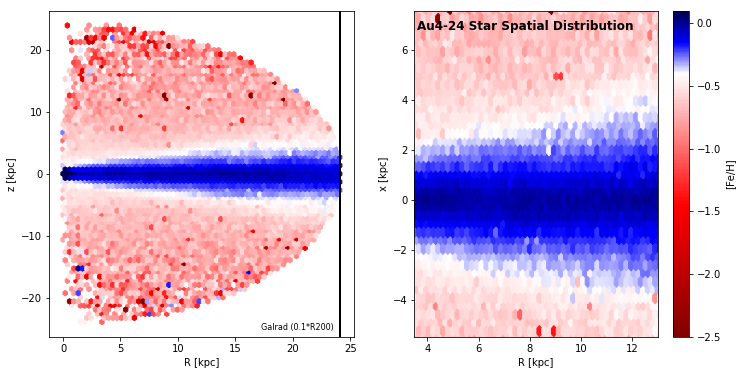

In [12]:
feabund = compute_iron_over_hydrogen_abundance(s, sf, istars)

fig, (ax2, ax1) = pyplot.subplots(1, 2, figsize=(12, 6))

norm = MidpointNormalize(midpoint=-0.4)
sc = ax1.hexbin(1000*rxy, 1000*z,
    C=feabund, edgecolors="none",
    gridsize=128, vmin=-2.5, vmax=0.1,
    cmap=pyplot.cm.get_cmap('seismic_r'), norm=norm)
ax1.set_xlabel("R [kpc]")
ax1.set_ylabel("x [kpc]")
ax1.text(0.01, 0.94, "Au{0}-{1} Star Spatial Distribution"\
    .format(s.level, s.halo_number),
    weight="bold", fontsize=12, transform=ax1.transAxes)
ax1.set_xlim(3.5, 13)
ax1.set_ylim(-5.45, 7.55)

sc = ax2.hexbin(1000*rxy, 1000*z,
    C=feabund, edgecolors="none",
    gridsize=64, vmin=-2.5, vmax=0.1,
    cmap=pyplot.cm.get_cmap('seismic_r'), norm=norm)
ax2.axvline(1000*s.galrad, c="k", lw=2)
trans = matplotlib.transforms.blended_transform_factory(
    ax2.transData, ax2.transAxes)
ax2.text(0.98*1000*s.galrad, 0.02, "Galrad (0.1*R200)",
    ha="right", fontsize=8, transform=trans)
ax2.set_xlabel("R [kpc]")
ax2.set_ylabel("z [kpc]")
ax2.text(0.01, 0.94, "Au{0}-{1} Star Spatial Distribution"\
    .format(s.level, s.halo_number),
    weight="bold", fontsize=12, transform=ax1.transAxes)

cax = pyplot.colorbar(sc)
cax.set_label("[Fe/H]")

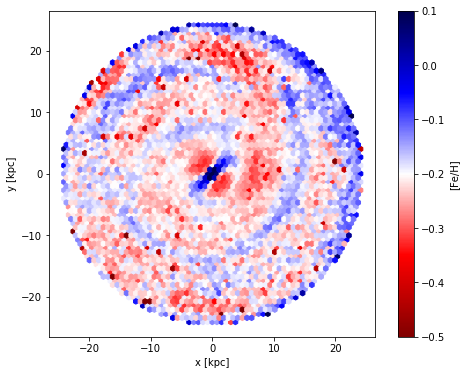

In [13]:
fig, ax = pyplot.subplots(figsize=(8, 6))

sc = ax.hexbin(1000*x, 1000*y,
    C=feabund, edgecolors="none",
    gridsize=64, vmin=-0.5, vmax=0.1,
    cmap=pyplot.cm.get_cmap('seismic_r'))
ax.set_xlabel("x [kpc]")
ax.set_ylabel("y [kpc]")
ax.set_aspect("equal")

cax = pyplot.colorbar(sc)
cax.set_label("[Fe/H]")

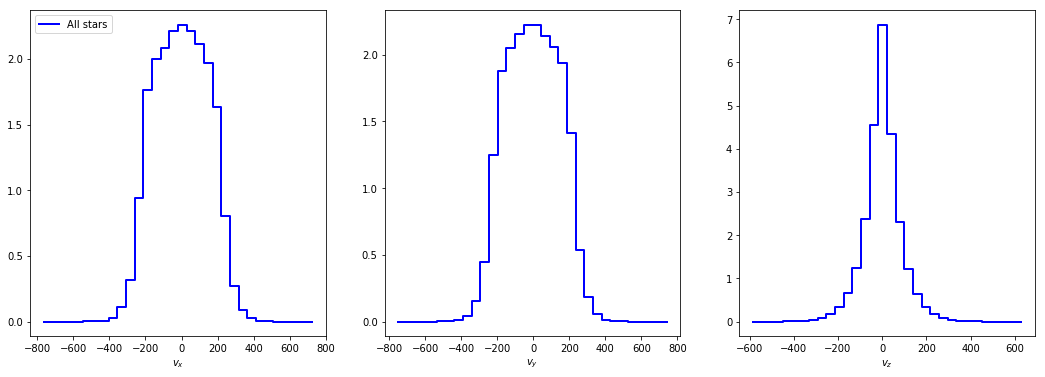

In [14]:
fig, (ax1, ax2, ax3) = pyplot.subplots(1, 3, figsize=(18, 6))

bins, edges = numpy.histogram(vx, bins=32, normed=True)
ax1.plot((edges[:-1] + edges[1:])/2, 1000*bins, ls="steps-mid",
         lw=2, c="b", label="All stars")
ax1.legend(loc="upper left")
ax1.set_xlabel(r"$v_x$")

bins, edges = numpy.histogram(vy, bins=32, normed=True)
ax2.plot((edges[:-1] + edges[1:])/2, 1000*bins, ls="steps-mid", 
         lw=2, c="b", label="All stars")
ax2.set_xlabel(r"$v_y$")

bins, edges = numpy.histogram(vz, bins=32, normed=True)
ax3.plot((edges[:-1] + edges[1:])/2, 1000*bins, ls="steps-mid",
         lw=2, c="b", label="All stars")
ax3.set_xlabel(r"$v_z$")

In [15]:
prod = x*vx + y*vy + z*vz
prod1 = x*vx + y*vy

v = numpy.sqrt( p2(vx) + p2(vy) + p2(vz) )
vm = numpy.sqrt(  p2(v) - p2(vz) )
vr = prod1 / rxy
vt = numpy.sqrt( numpy.abs(p2(vm) - p2(vr) ))

lz = x*vy - y*vx
ilz, = numpy.where(lz > 0)  # >0 instead of <0. Why?
print("len(lz)  : {0}\nlen(lz<0): {1}".format(len(lz), len(ilz)))

vt[ilz] = vt[ilz] * -1


len(lz)  : 1783163
len(lz<0): 291585


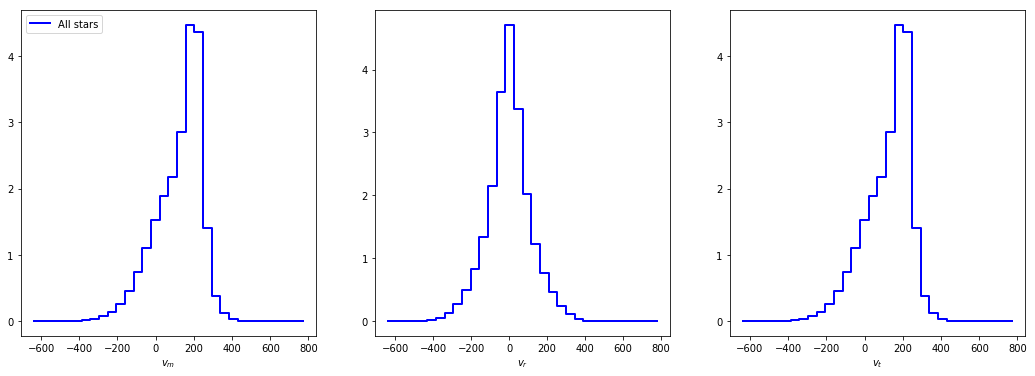

In [16]:
fig, (ax1, ax2, ax3) = pyplot.subplots(1, 3, figsize=(18, 6))

bins, edges = numpy.histogram(vt, bins=32, normed=True)
ax1.plot((edges[:-1] + edges[1:])/2, 1000*bins, ls="steps-mid",
         lw=2, c="b", label="All stars")
ax1.legend(loc="upper left")
ax1.set_xlabel(r"$v_m$")

bins, edges = numpy.histogram(vr, bins=32, normed=True)
ax2.plot((edges[:-1] + edges[1:])/2, 1000*bins, ls="steps-mid", 
         lw=2, c="b", label="All stars")
ax2.set_xlabel(r"$v_r$")

bins, edges = numpy.histogram(vt, bins=32, normed=True)
ax3.plot((edges[:-1] + edges[1:])/2, 1000*bins, ls="steps-mid",
         lw=2, c="b", label="All stars")
ax3.set_xlabel(r"$v_t$")

# Local Torus

In [17]:
R = numpy.sqrt( p2(s.pos[::,1]) + p2(s.pos[::,2]) )
ilocal, = numpy.where( 
    (s.type == 4) & (s.halo == 0) & (s.r() > 0.) & (s.r() < s.galrad) &
    (R > 6.0/1000) & (R < 10.0/1000) & (numpy.abs(s.pos[::,0]) < 2.0/1000)
)

(x1, y1, z1), (vx1, vy1, vz1), rxyz1, rxy1 = get_cartesian_vectors(s, sf, ilocal)
print("istars: {0}\nilocal: {1}".format(len(istars), len(ilocal)))

istars: 1783163
ilocal: 166916


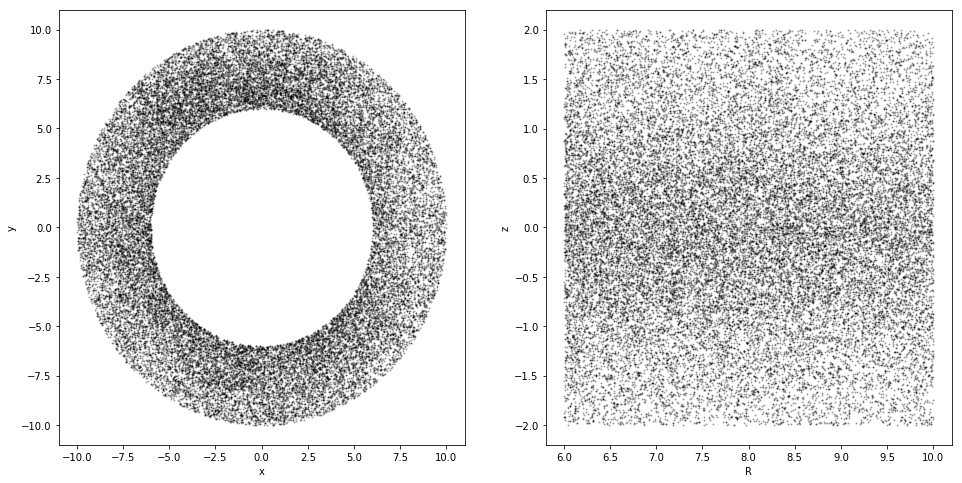

In [18]:
mask = numpy.random.randint(0, len(x1), 32384)

fig, (ax1, ax2) = pyplot.subplots(1, 2, figsize=(16, 8))
ax1.plot(1000*x1[mask], 1000*y1[mask], "kD", ms=1, alpha=0.25)
ax1.set_xlabel("x")
ax1.set_ylabel("y")

ax2.plot(1000*rxy1[mask], 1000*z1[mask], "kD", ms=1, alpha=0.25)
ax2.set_xlabel("R")
ax2.set_ylabel("z")

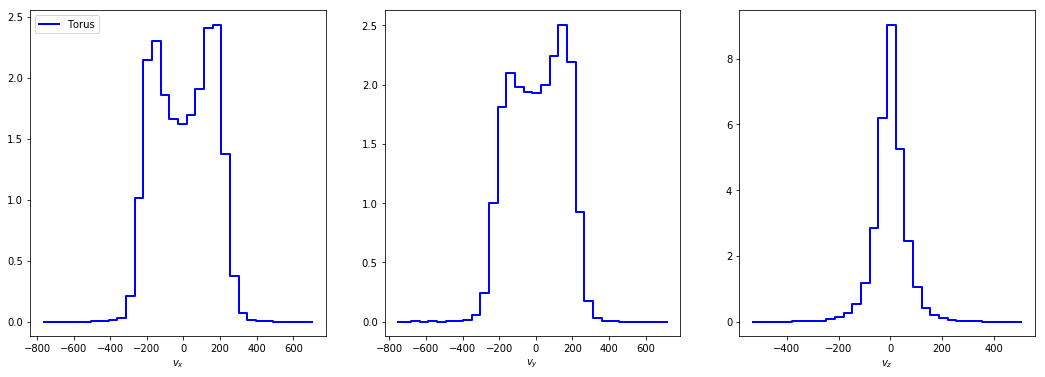

In [19]:
fig, (ax1, ax2, ax3) = pyplot.subplots(1, 3, figsize=(18, 6))

bins, edges = numpy.histogram(vx1, bins=32, normed=True)
ax1.plot((edges[:-1] + edges[1:])/2, 1000*bins, ls="steps-mid",
         lw=2, c="b", label="Torus")
ax1.legend(loc="upper left")
ax1.set_xlabel(r"$v_x$")

bins, edges = numpy.histogram(vy1, bins=32, normed=True)
ax2.plot((edges[:-1] + edges[1:])/2, 1000*bins, ls="steps-mid", 
         lw=2, c="b", label="Torus")
ax2.set_xlabel(r"$v_y$")

bins, edges = numpy.histogram(vz1, bins=32, normed=True)
ax3.plot((edges[:-1] + edges[1:])/2, 1000*bins, ls="steps-mid",
         lw=2, c="b", label="Torus")
ax3.set_xlabel(r"$v_z$")

len(lz1)  : 166916
len(lz1>0): 8586


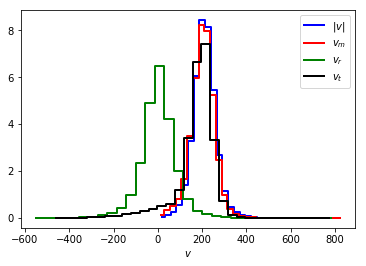

In [20]:
prod = x1*vx1 + y1*vy1 + z1*vz1
prod1 = x1*vx1 + y1*vy1

v1 = numpy.sqrt( p2(vx1) + p2(vy1) + p2(vz1) )
vm1 = numpy.sqrt(  p2(v1) - p2(vz1) )
vr1 = prod1 / rxy1
vt1 = numpy.sqrt( numpy.abs(p2(vm1) - p2(vr1)) )

lz1 = x1*vy1 - y1*vx1
ilz1, = numpy.where(lz1 > 0)  # >0 instead of <0. Why?
print("len(lz1)  : {0}\nlen(lz1>0): {1}".format(len(lz1), len(ilz1)))

vt1[ilz1] = vt1[ilz1] * -1

fig, ax1 = pyplot.subplots()
bins, edges = numpy.histogram(v1, bins=32, normed=True)
ax1.plot((edges[:-1] + edges[1:])/2, 1000*bins, ls="steps-mid",
         lw=2, c="b", label=r"$|v|$")
bins, edges = numpy.histogram(vm1, bins=32, normed=True)
ax1.plot((edges[:-1] + edges[1:])/2, 1000*bins, ls="steps-mid",
         lw=2, c="r", label=r"$v_m$")
bins, edges = numpy.histogram(vr1, bins=32, normed=True)
ax1.plot((edges[:-1] + edges[1:])/2, 1000*bins, ls="steps-mid",
         lw=2, c="g", label=r"$v_r$")
bins, edges = numpy.histogram(vt1, bins=32, normed=True)
ax1.plot((edges[:-1] + edges[1:])/2, 1000*bins, ls="steps-mid",
         lw=2, c="k", label=r"$v_t$")
ax1.legend(loc="upper right")
ax1.set_xlabel(r"$v$")


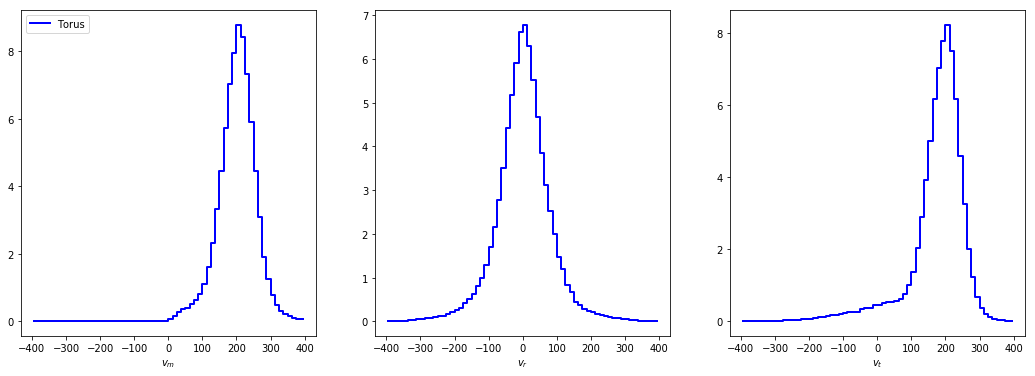

In [21]:
fig, (ax1, ax2, ax3) = pyplot.subplots(1, 3, figsize=(18, 6))

nbins = 64
range = (-400, +400)

bins, edges = numpy.histogram(vm1, bins=nbins, range=range, normed=True)
ax1.plot((edges[:-1] + edges[1:])/2, 1000*bins, ls="steps-mid",
         lw=2, c="b", label="Torus")
ax1.legend(loc="upper left")
ax1.set_xlabel(r"$v_m$")

bins, edges = numpy.histogram(vr1, bins=nbins, range=range, normed=True)
ax2.plot((edges[:-1] + edges[1:])/2, 1000*bins, ls="steps-mid", 
         lw=2, c="b", label="Torus")
ax2.set_xlabel(r"$v_r$")

bins, edges = numpy.histogram(vt1, bins=nbins, range=range, normed=True)
ax3.plot((edges[:-1] + edges[1:])/2, 1000*bins, ls="steps-mid",
         lw=2, c="b", label="Torus")
ax3.set_xlabel(r"$v_t$")

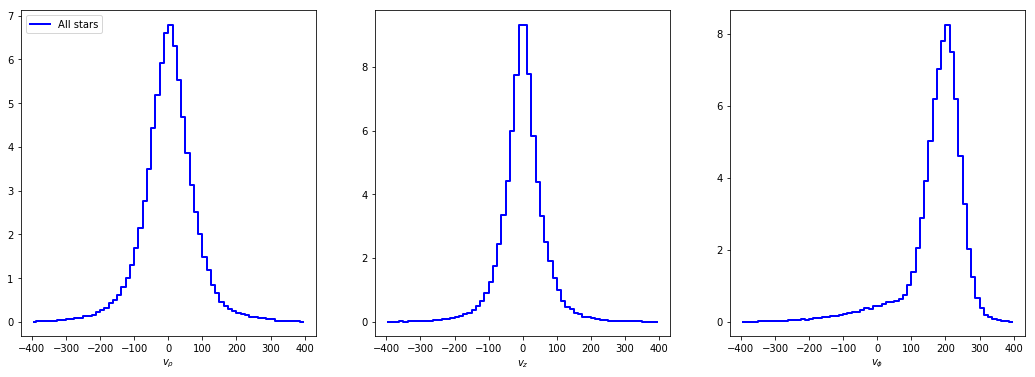

In [22]:
v_rho1 = (x1*vx1 + y1*vy1) / rxy1

# direction along heigth of the disk
v_z1 = vz1

# radial velocity
# v_phi = r dphi/dt. r = sqrt(x^2+y^2), phi = numpy.arctan2(y, x)
# dphi_dt = (x dx/dt - y dy/dt) / (x^2 + y^2)
v_phi1 = ( x1*vy1 - y1*vx1 ) / rxy1
v_phi1 *= -1  # why?

fig, (ax1, ax2, ax3) = pyplot.subplots(1, 3, figsize=(18, 6))

bins, edges = numpy.histogram(v_rho1, bins=nbins, range=range, normed=True)
ax1.plot((edges[:-1] + edges[1:])/2, 1000*bins, ls="steps-mid",
         lw=2, c="b", label="All stars")
ax1.legend(loc="upper left")
ax1.set_xlabel(r"$v_\rho$")

bins, edges = numpy.histogram(v_z1, bins=nbins, range=range, normed=True)
ax2.plot((edges[:-1] + edges[1:])/2, 1000*bins, ls="steps-mid", 
         lw=2, c="b", label="All stars")
ax2.set_xlabel(r"$v_z$")

bins, edges = numpy.histogram(v_phi1, bins=nbins, range=range, normed=True)
ax3.plot((edges[:-1] + edges[1:])/2, 1000*bins, ls="steps-mid",
         lw=2, c="b", label="All stars")
ax3.set_xlabel(r"$v_\phi$")

# Local Box

In [17]:
def build_solar_box(s, sf, r_sun, angle, boxsize, z_sun=15.0/1000/1000):
    """ Cut a box of particles in the Solar neighbourhood.
        @param s, sf: gadget snapshot s with its subfind counterpart sf
        @param r_sun: radius of the Sun (use 8.0/1000 for 8 kpc)
        @param angle: angle in the xy-plane (use values in [0, 2pi])
        @param boxsize: size of the box (use 2.0/1000 for 2 kpc)
        @param z_sun: Sun is 15 parsec above the plane z=0

        @return indices of particles (of any type, but only in s.haloid)
        """

    x_sun = r_sun * numpy.cos(angle)
    y_sun = r_sun * numpy.sin(angle)

    isolarbox, = numpy.where( (s.halo == s.haloid)
        & (s.pos[::,2] > x_sun-boxsize) & (s.pos[::,2] < x_sun+boxsize)
        & (s.pos[::,1] > y_sun-boxsize) & (s.pos[::,1] < y_sun+boxsize)
        & (s.pos[::,0] > z_sun-boxsize) & (s.pos[::,0] < z_sun+boxsize)
    )

    return isolarbox


def get_solar_box_dm(s, sf, r_sun, angle, boxsize, verbose=False):
    ndm = s.nparticlesall[1] + s.nparticlesall[2] + s.nparticlesall[3]

    # Scoop up all dark matter particle types: 1 (halo), 2 (disk), 3 (bulge).
    halo_disk_bulge = numpy.concatenate((
        numpy.where(s.type == 1)[0],
        numpy.where(s.type == 2)[0],
        numpy.where(s.type == 3)[0])
    )

    if ndm != len(halo_disk_bulge):
        verbose = True
        print("ERROR: DM particles in cut vs. total DM particles differ:")

    if verbose:
        print("# DM particles in cut   : {0}".format(len(halo_disk_bulge)))
        print("Sum nparticlesall[1,2,3]: {0}".format(ndm))

    return numpy.intersect1d( halo_disk_bulge,
        build_solar_box(s, sf, r_sun, angle, boxsize) )


def get_solar_box_stars(s, sf, r_sun, angle, boxsize):
    istars, = numpy.where(s.type == 4)

    return numpy.intersect1d( istars,
        build_solar_box(s, sf, r_sun, angle, boxsize) )


In [26]:
def test_solar_box(ax, ax2, angle, stars=True):
    print("Building Solar Box for angle={0}".format(angle))
    
    ax.cla()
    ax2.cla()

    r_sun = 8.0/1000
    boxsize = 2.0/1000

    # repeated here what lives in build_solar_box. Please verify!
    x_sun = r_sun * numpy.cos(angle)
    y_sun = r_sun * numpy.sin(angle)
    z_sun = 15.0/1000/1000

    if stars:
        isolarbox = get_solar_box_stars(
            s, sf, r_sun, angle, boxsize)
    else:
        isolarbox = get_solar_box_dm(
            s, sf, r_sun, angle, boxsize)

    (x, y, z), (vx, vy, vz), rxyz, rxy =\
        get_cartesian_vectors(s, sf, isolarbox)
    ax.plot(1000*x, 1000*y, "kD", ms=1)
    ax.plot(1000*x_sun, 1000*y_sun, "ro", ms=10)
    circle = numpy.arange(0, 2*numpy.pi, 0.01)
    ax.plot(1000*r_sun*numpy.sin(circle), 1000*r_sun*numpy.cos(circle),
            lw=1, c="b", ls="dashed")
    ax.axhline(1000*y_sun, c="r", lw=1, ls="dotted")
    ax.axvline(1000*x_sun, c="r", lw=1, ls="dotted")
    ax.axvline(1000*(x_sun-boxsize), c="g", lw=1, ls="dashed")
    ax.axvline(1000*(x_sun+boxsize), c="g", lw=1, ls="dashed")
    ax.axhline(1000*(y_sun-boxsize), c="g", lw=1, ls="dashed")
    ax.axhline(1000*(y_sun+boxsize), c="g", lw=1, ls="dashed")
    ax.set_xlim(-20, 20)
    ax.set_ylim(-20, 20)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_aspect("equal")
    # ax.figure.savefig("out/debug_SolarNeighbourhood_rsun"+
    #     "={0:1.1f}_angle={1:1.1f}_boxsize={2:1.1f}_xy-plane_{3}.png"\
    #    .format(1000*r_sun, angle, 1000*boxsize, "stars" if stars else "dm"))

    ax2.plot(1000*rxy, 1000*z, "kD", ms=1)
    ax2.plot(1000*r_sun, 1000*z_sun, "ro", ms=10)
    ax2.axvline(1000*(r_sun-boxsize), c="g", lw=1, ls="dashed")
    ax2.axvline(1000*(r_sun+boxsize), c="g", lw=1, ls="dashed")
    ax2.axhline(1000*(z_sun-boxsize), c="g", lw=1, ls="dashed")
    ax2.axhline(1000*(z_sun+boxsize), c="g", lw=1, ls="dashed")
    ax2.set_xlim(-20, 20)
    ax2.set_ylim(-20, 20)

    ax2.axvline(1000*numpy.sqrt(p2(x_sun)+p2(y_sun)), c="r", lw=1, ls="dotted")
    ax2.axhline(1000*z_sun, c="r", lw=1, ls="dotted")
    ax2.set_xlabel("R")
    ax2.set_ylabel("z")
    ax2.set_aspect("equal")
    # ax2.figure.savefig("out/debug_SolarNeighbourhood_rsun"+
    #     "={0:1.1f}_angle={1:1.1f}_boxsize={2:1.1f}_Rz-plane_{3}.png"\
    #     .format(1000*r_sun, angle, 1000*boxsize, "stars" if stars else "dm"))

In [27]:
%matplotlib notebook

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

<IPython.core.display.Javascript object>


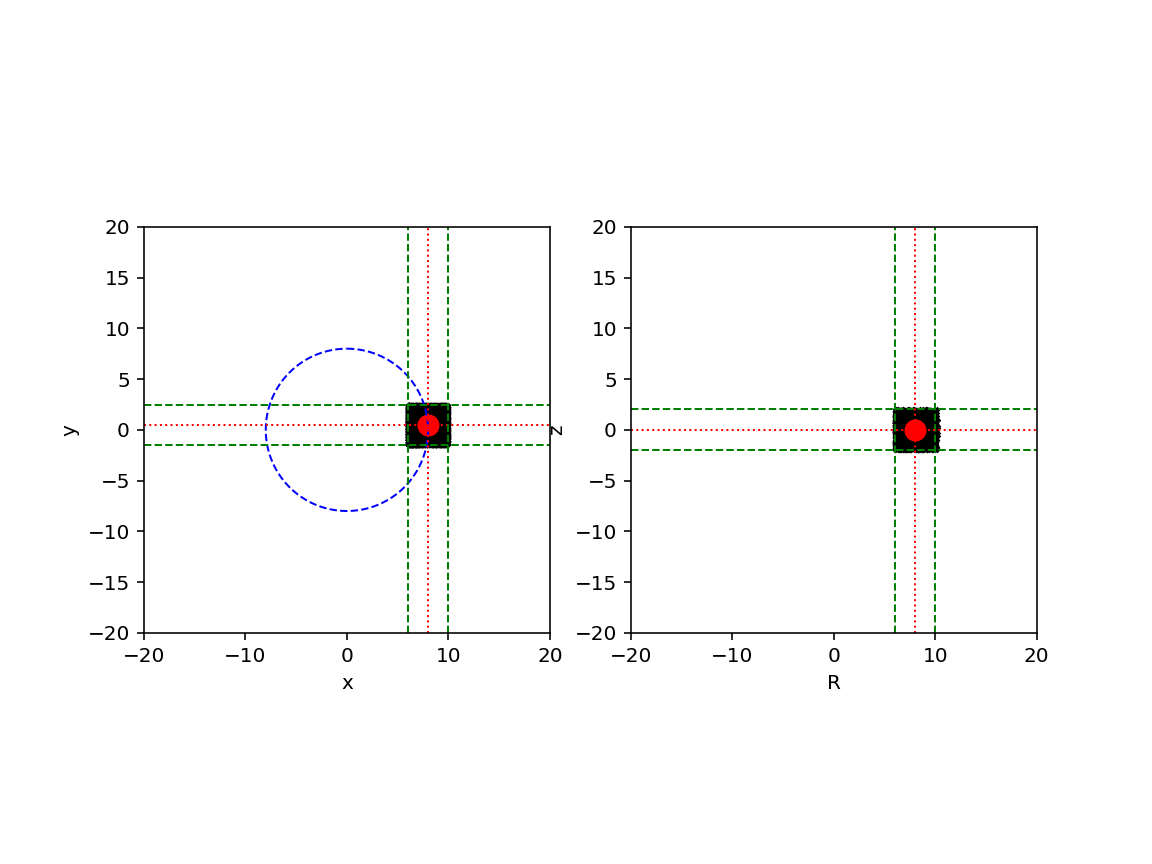

In [28]:
fig, (ax, ax2) = pyplot.subplots(1, 2, figsize=(8, 6))
interactive(test_solar_box, ax=fixed(ax), ax2=fixed(ax2),
            s=fixed(s), sf=fixed(sf), stars=fixed(True),
            angle=(-numpy.pi, numpy.pi), continuous_update=False)

# Local Sphere

In [29]:
def build_solar_sphere(s, sf, r_sun, angle, radius, z_sun=15.0/1000/1000):
    """ Cut a sphere of particles in the Solar neighbourhood.
        @param s, sf: gadget snapshot s with its subfind counterpart sf
        @param r_sun: radius of the Sun (use 8.0/1000 for 8 kpc)
        @param angle: angle in the xy-plane (use values in [0, 2pi])
        @param radius: radius of the local sphere (use 5.0/1000 for 5 kpc)
        @param z_sun: Sun is 15 parsec above the plane z=0

        @return indices of particles (of any type, but only in s.haloid)
        """

    x_sun = r_sun * numpy.cos(angle)
    y_sun = r_sun * numpy.sin(angle)

    isolarsphere, = numpy.where( (s.halo == s.haloid)
        & ( numpy.sqrt(p2(s.pos[::,2] - x_sun) + p2(s.pos[::,1] - y_sun)
                       + p2(s.pos[::,0] - z_sun) ) < radius )
    )

    return isolarsphere


def get_solar_sphere_dm(s, sf, r_sun, angle, radius, verbose=False):
    ndm = s.nparticlesall[1] + s.nparticlesall[2] + s.nparticlesall[3]

    # Scoop up all dark matter particle types: 1 (halo), 2 (disk), 3 (bulge).
    halo_disk_bulge = numpy.concatenate((
        numpy.where(s.type == 1)[0],
        numpy.where(s.type == 2)[0],
        numpy.where(s.type == 3)[0])
    )

    if ndm != len(halo_disk_bulge):
        verbose = True
        print("ERROR: DM particles in cut vs. total DM particles differ:")

    if verbose:
        print("# DM particles in cut   : {0}".format(len(halo_disk_bulge)))
        print("Sum nparticlesall[1,2,3]: {0}".format(ndm))

    return numpy.intersect1d( halo_disk_bulge,
        build_solar_sphere(s, sf, r_sun, angle, radius) )


def get_solar_sphere_stars(s, sf, r_sun, angle, radius):
    istars, = numpy.where(s.type == 4)

    return numpy.intersect1d( istars,
        build_solar_sphere(s, sf, r_sun, angle, radius) )

In [30]:
def test_solar_sphere(ax, ax2, angle, radius, stars=True):
    print("Building Solar sphere for angle={0}".format(angle))

    ax.cla()
    ax2.cla()
    
    r_sun = 8.0/1000
    radius = radius/1000

    # repeated here what lives in build_solar_sphere. Please verify!
    x_sun = r_sun * numpy.cos(angle)
    y_sun = r_sun * numpy.sin(angle)
    z_sun = 15.0/1000/1000

    if stars:
        isolarsphere = get_solar_sphere_stars(
                s, sf, r_sun, angle, radius)
    else:
        isolarsphere = get_solar_sphere_dm(
                s, sf, r_sun, angle, radius)
        
    (x, y, z), (vx, vy, vz), rxyz, rxy =\
        get_cartesian_vectors(s, sf, isolarsphere)
    ax.plot(1000*x, 1000*y, "kD", ms=1)
    ax.plot(1000*x_sun, 1000*y_sun, "ro", ms=10)
    circle = numpy.arange(0, 2*numpy.pi, 0.01)
    ax.plot(1000*r_sun*numpy.sin(circle), 1000*r_sun*numpy.cos(circle),
            lw=1, c="b", ls="dashed")
    ax.axhline(1000*y_sun, c="r", lw=1, ls="dotted")
    ax.axvline(1000*x_sun, c="r", lw=1, ls="dotted")
    ax.axvline(1000*(x_sun-radius), c="g", lw=1, ls="dashed")
    ax.axvline(1000*(x_sun+radius), c="g", lw=1, ls="dashed")
    ax.axhline(1000*(y_sun-radius), c="g", lw=1, ls="dashed")
    ax.axhline(1000*(y_sun+radius), c="g", lw=1, ls="dashed")
    ax.set_xlim(-20, 20)
    ax.set_ylim(-20, 20)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_aspect("equal")
    # ax.figure.savefig("out/debug_SolarNeighbourhood_rsun"+
    #     "={0:1.1f}_angle={1:1.1f}_radius={2:1.1f}_xy-plane_{3}.png"\
    #     .format(1000*r_sun, angle, 1000*radius, "stars" if stars else "dm"))

    ax2.plot(1000*rxy, 1000*z, "kD", ms=1)
    ax2.plot(1000*r_sun, 1000*z_sun, "ro", ms=10)
    ax2.axvline(1000*(r_sun-radius), c="g", lw=1, ls="dashed")
    ax2.axvline(1000*(r_sun+radius), c="g", lw=1, ls="dashed")
    ax2.axhline(1000*(z_sun-radius), c="g", lw=1, ls="dashed")
    ax2.axhline(1000*(z_sun+radius), c="g", lw=1, ls="dashed")
    ax2.set_xlim(-20, 20)
    ax2.set_ylim(-20, 20)

    ax2.axvline(1000*numpy.sqrt(p2(x_sun)+p2(y_sun)), c="r", lw=1, ls="dotted")
    ax2.axhline(1000*z_sun, c="r", lw=1, ls="dotted")
    ax2.set_xlabel("R")
    ax2.set_ylabel("z")
    ax2.set_aspect("equal")
    # ax2.figure.savefig("out/debug_SolarNeighbourhood_rsun"+
    #     "={0:1.1f}_angle={1:1.1f}_radius={2:1.1f}_Rz-plane_{3}.png"\
    #    .format(1000*r_sun, angle, 1000*radius, "stars" if stars else "dm"))

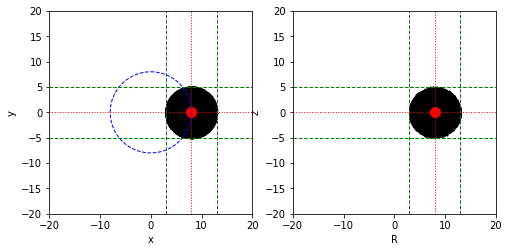

In [135]:
fig, (ax, ax2) = pyplot.subplots(1, 2, figsize=(8, 6))
interactive(test_solar_sphere, ax=fixed(ax), ax2=fixed(ax2),
            stars=fixed(True), angle=(-numpy.pi, numpy.pi), radius=(2, 8),
            continuous_update=False)

In [36]:
r_sun = 8.0/1000
angle = 0.0
radius = 5.0/1000

# repeated here what lives in build_solar_sphere. Please verify!
x_sun = r_sun * numpy.cos(angle)
y_sun = r_sun * numpy.sin(angle)
z_sun = 15.0/1000/1000

isolarsphere = get_solar_sphere_stars(
    s, sf, r_sun, angle, radius)

isolarsphere_dm = get_solar_sphere_dm(
    s, sf, r_sun, angle, radius)

(x, y, z), (vx, vy, vz), rxyz, rxy = get_cartesian_vectors(s, sf, isolarsphere)
print("istars         : {0}\nisolarsphere   : {1}".format(len(istars), len(isolarsphere)))

(xdm, ydm, zdm), (vxdm, vydm, vzdm), rxyzdm, rxydm = get_cartesian_vectors(s, sf, isolarsphere_dm)
print("isolarsphere_dm: {1}".format(len(istars), len(isolarsphere_dm)))

istars         : 1783163
isolarsphere   : 74267
isolarsphere_dm: 19139


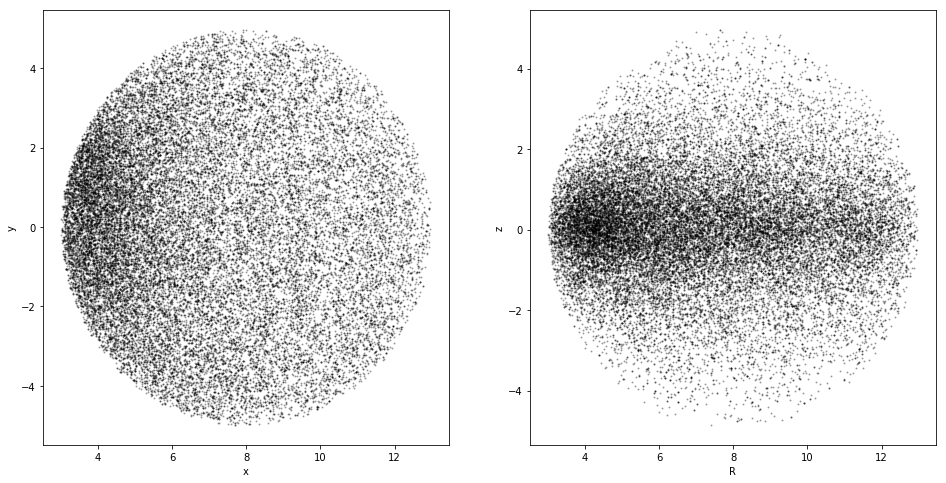

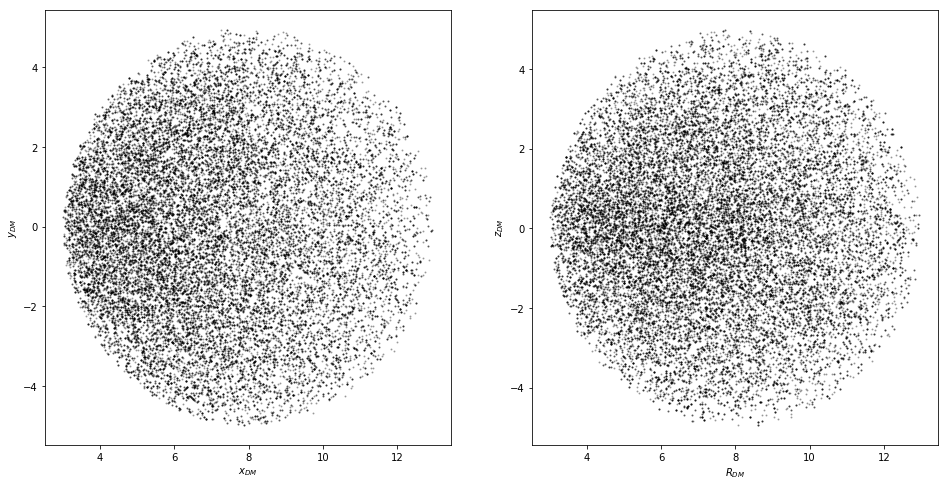

In [39]:
%matplotlib inline

mask = numpy.random.randint(0, len(x), 32384)

fig, (ax1, ax2) = pyplot.subplots(1, 2, figsize=(16, 8))
ax1.plot(1000*x[mask], 1000*y[mask], "kD", ms=1, alpha=0.25)
ax1.set_xlabel("x")
ax1.set_ylabel("y")

ax2.plot(1000*rxy[mask], 1000*z[mask], "kD", ms=1, alpha=0.25)
ax2.set_xlabel("R")
ax2.set_ylabel("z")

mask = numpy.random.randint(0, len(xdm), 32384)
fig, (ax1, ax2) = pyplot.subplots(1, 2, figsize=(16, 8))
ax1.plot(1000*xdm[mask], 1000*ydm[mask], "kD", ms=1, alpha=0.25)
ax1.set_xlabel(r"$x_{DM}$")
ax1.set_ylabel(r"$y_{DM}$")

ax2.plot(1000*rxydm[mask], 1000*zdm[mask], "kD", ms=1, alpha=0.25)
ax2.set_xlabel(r"$R_{DM}$")
ax2.set_ylabel(r"$z_{DM}}$")

In [55]:
print(s.nparticlesall[1])
print(len(numpy.where(s.type[isolarsphere_dm] == 1)[0]))

print(s.nparticlesall[2])
print(len(numpy.where(s.type[isolarsphere_dm] == 2)[0]))

print(s.nparticlesall[3])
print(len(numpy.where(s.type[isolarsphere_dm] == 3)[0]))

33457347
19139
571135
0
869605
0


In [66]:
r_sun = 8.0/1000
angle = 0
x_sun = r_sun * numpy.cos(angle)
y_sun = r_sun * numpy.sin(angle)

isolarsphere, = numpy.where( (s.halo == s.haloid)
    & ( numpy.sqrt(p2(s.pos[::,2] - x_sun) + p2(s.pos[::,1] - y_sun)
                   + p2(s.pos[::,0] - z_sun) ) < radius )
)

idm, = numpy.where(
    (s.halo == s.haloid) & 
    ( numpy.sqrt(p2(s.pos[::,2] - x_sun) + p2(s.pos[::,1] - y_sun) + p2(s.pos[::,0] - z_sun) ) < radius ) &
    ((s.type == 1) | (s.type == 2) | (s.type == 3))
)

print(len(idm))
print(len(isolarsphere_dm))

19139
19139


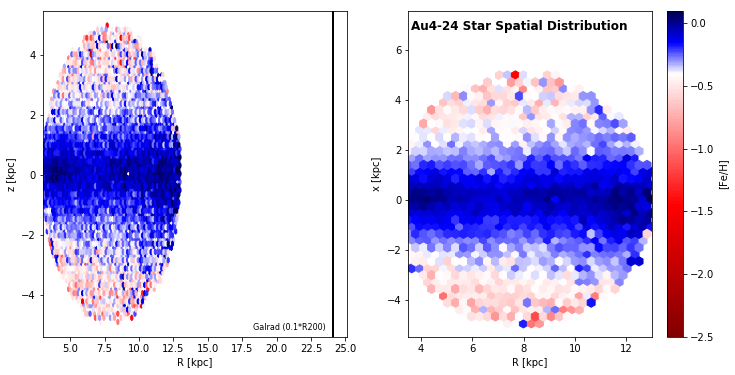

In [41]:
feabund = compute_iron_over_hydrogen_abundance(s, sf, isolarsphere)

fig, (ax2, ax1) = pyplot.subplots(1, 2, figsize=(12, 6))

norm = MidpointNormalize(midpoint=-0.4)
sc = ax1.hexbin(1000*rxy, 1000*z,
    C=feabund, edgecolors="none",
    gridsize=32, vmin=-2.5, vmax=0.1,
    cmap=pyplot.cm.get_cmap('seismic_r'), norm=norm)
ax1.set_xlabel("R [kpc]")
ax1.set_ylabel("x [kpc]")
ax1.text(0.01, 0.94, "Au{0}-{1} Star Spatial Distribution"\
    .format(s.level, s.halo_number),
    weight="bold", fontsize=12, transform=ax1.transAxes)
ax1.set_xlim(3.5, 13)
ax1.set_ylim(-5.45, 7.55)

sc = ax2.hexbin(1000*rxy, 1000*z,
    C=feabund, edgecolors="none",
    gridsize=64, vmin=-2.5, vmax=0.1,
    cmap=pyplot.cm.get_cmap('seismic_r'), norm=norm)
ax2.axvline(1000*s.galrad, c="k", lw=2)
trans = matplotlib.transforms.blended_transform_factory(
    ax2.transData, ax2.transAxes)
ax2.text(0.98*1000*s.galrad, 0.02, "Galrad (0.1*R200)",
    ha="right", fontsize=8, transform=trans)
ax2.set_xlabel("R [kpc]")
ax2.set_ylabel("z [kpc]")
ax2.text(0.01, 0.94, "Au{0}-{1} Star Spatial Distribution"\
    .format(s.level, s.halo_number),
    weight="bold", fontsize=12, transform=ax1.transAxes)

cax = pyplot.colorbar(sc)
cax.set_label("[Fe/H]")

In [71]:
def convert_cartesian_vel_to_cylindrical(s, sf, mask):
    """ Auriga postprocessing scripts are in cartesian coordinates.
        Here we convert velocities to cylindrical coorinates
          v_rho: radial velocity [ rho = sqrt(xx + yy) ]
          v_z  : vertical velocity
          v_phi: angular velocity """

    (x, y, z), (vx, vy, vz), rxyz, rxy = get_cartesian_vectors(s, sf, mask)

    # line of sight velocity?
    # v_rho = dr/dt = d(sqrt(xx+yy))/dt = (x dx/dt + y dy/dt) / sqrt(xx+yy)
    v_rho = (x*vx + y*vy) / rxy

    # direction along heigth of the disk
    v_z = vz

    # radial velocity
    # v_phi = r dphi/dt. r = sqrt(x^2+y^2), phi = numpy.arctan2(y, x)
    # dphi_dt = (x dx/dt - y dy/dt) / (x^2 + y^2)

    v_phi = -1.0 * (x*vy - y*vx ) / rxy

    # spherical?
    # rr = np.sqrt( (s.pos[istars]**2).sum(axis=1) )
    # vrad[:] = ( (s.pos[istars, 0]*s.vel[istars, 0]) +
    #     (s.pos[istars, 1]*s.vel[istars, 1]) +
    #     (s.pos[istars, 2]*s.vel[istars, 2]) ) / rr[:]

    return v_rho, v_z, v_phi


Stars in the galaxy      : 1783163
Local Stars              : 93406
Local Stars [Fe/H] < -1.5: 460
Local Stars [Fe/H] < -1.8: 200
Local Stars [Fe/H] < -1  : 2125
Local Stars [Fe/H] < -2  : 101
Local Stars [Fe/H] < -3  : 17
Local Dark Matter        : 19139


(0, 8.5)

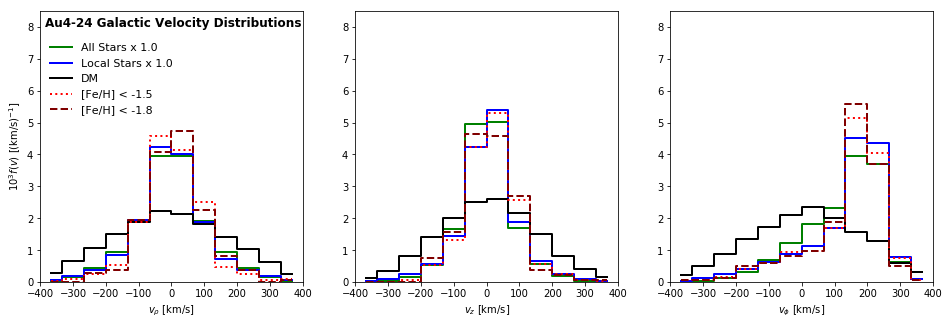

In [149]:
v_rho_stars, v_z_stars, v_phi_stars = \
    convert_cartesian_vel_to_cylindrical(s, sf, istars)
    
v_rho_local, v_z_local, v_phi_local = \
    convert_cartesian_vel_to_cylindrical(s, sf, isolarsphere)
    
v_rho_dm, v_z_dm, v_phi_dm = \
    convert_cartesian_vel_to_cylindrical(s, sf, isolarsphere_dm)

metalcut15, = numpy.where(feabund < -1.5)
metalcut18, = numpy.where(feabund < -1.8)
    
metalcut1, = numpy.where(feabund < -1)
metalcut2, = numpy.where(feabund < -2)
metalcut3, = numpy.where(feabund < -3)

print("Stars in the galaxy      : {0}".format(len(istars)))
print("Local Stars              : {0}".format(len(isolarsphere)))
print("Local Stars [Fe/H] < -1.5: {0}".format(len(metalcut15)))
print("Local Stars [Fe/H] < -1.8: {0}".format(len(metalcut18)))
print("Local Stars [Fe/H] < -1  : {0}".format(len(metalcut1)))
print("Local Stars [Fe/H] < -2  : {0}".format(len(metalcut2)))
print("Local Stars [Fe/H] < -3  : {0}".format(len(metalcut3)))
print("Local Dark Matter        : {0}".format(len(isolarsphere_dm)))

fig, (ax1, ax2, ax3) = pyplot.subplots(1, 3,
    sharey=False, sharex=True, figsize=(16, 5))

# General plot properties
nbins = 12
range = (-400, +400)
star_reduction_factor = 1
ymin, ymax = 0, 8.5

# And now a littlebit of bookkeeping
plot_all = True
if plot_all:
    alllabel = "All Stars x {0:.1f}".format(star_reduction_factor)
    bins, edges = numpy.histogram(v_rho_stars,
        bins=nbins, normed=True, range=range)
    ax1.plot((edges[:-1] + edges[1:])/2, star_reduction_factor*1000*bins,
        ls="steps-mid", lw=2, c="green", label=alllabel)
    bins, edges = numpy.histogram(v_z_stars,
        bins=nbins, normed=True, range=range)
    ax2.plot((edges[:-1] + edges[1:])/2, star_reduction_factor*1000*bins,
        ls="steps-mid", lw=2, c="green", label=alllabel)
    bins, edges = numpy.histogram(v_phi_stars,
        bins=nbins, normed=True, range=range)
    ax3.plot((edges[:-1] + edges[1:])/2, star_reduction_factor*1000*bins,
        ls="steps-mid", lw=2, c="green", label=alllabel)

plot_local = True
if plot_local:
    locallabel="Local Stars x {0:.1f}".format(star_reduction_factor)
    bins, edges = numpy.histogram(v_rho_local,
        bins=nbins, normed=True, range=range)
    ax1.plot((edges[:-1] + edges[1:])/2, star_reduction_factor*1000*bins,
        ls="steps-mid", lw=2, c="blue", label=locallabel)
    bins, edges = numpy.histogram(v_z_local,
        bins=nbins, normed=True, range=range)
    ax2.plot((edges[:-1] + edges[1:])/2, star_reduction_factor*1000*bins,
        ls="steps-mid", lw=2, c="blue", label=locallabel)
    bins, edges = numpy.histogram(v_phi_local,
        bins=nbins, normed=True, range=range)
    ax3.plot((edges[:-1] + edges[1:])/2, star_reduction_factor*1000*bins,
        ls="steps-mid", lw=2, c="blue", label=locallabel)

plot_dm = True
if plot_dm:
    bins, edges = numpy.histogram(v_rho_dm,
        bins=nbins, normed=True, range=range)
    ax1.plot((edges[:-1] + edges[1:])/2, 1000*bins,
        ls="steps-mid", lw=2, c="black", label="DM")
    bins, edges = numpy.histogram(v_z_dm,
        bins=nbins, normed=True, range=range)
    ax2.plot((edges[:-1] + edges[1:])/2, 1000*bins,
        ls="steps-mid", lw=2, c="black", label="DM")
    bins, edges = numpy.histogram(v_phi_dm,
        bins=nbins, normed=True, range=range)
    ax3.plot((edges[:-1] + edges[1:])/2, 1000*bins,
        ls="steps-mid", lw=2, c="black", label="DM")

show_metalcut1 = False
if show_metalcut1:
    bins, edges = numpy.histogram(v_rho_local[metalcut1],
        bins=nbins, normed=True, range=range)
    ax1.plot((edges[:-1] + edges[1:])/2, 1000*bins,
        ls="dotted", drawstyle="steps-mid", lw=2, c="red",
        label="[Fe/H] < -1")
    bins, edges = numpy.histogram(v_z_local[metalcut1],
        bins=nbins, normed=True, range=range)
    ax2.plot((edges[:-1] + edges[1:])/2, 1000*bins,
        ls="dotted", drawstyle="steps-mid", lw=2, c="red",
        label="[Fe/H] < -1")
    bins, edges = numpy.histogram(v_phi_local[metalcut1],
        bins=nbins, normed=True, range=range)
    ax3.plot((edges[:-1] + edges[1:])/2, 1000*bins,
        ls="dotted", drawstyle="steps-mid", lw=2, c="red",
        label="[Fe/H] < -1")
    
show_metalcut15 = True
if show_metalcut15:
    bins, edges = numpy.histogram(v_rho_local[metalcut15],
        bins=nbins, normed=True, range=range)
    ax1.plot((edges[:-1] + edges[1:])/2, 1000*bins,
        ls="dotted", drawstyle="steps-mid", lw=2, c="red",
        label="[Fe/H] < -1.5")
    bins, edges = numpy.histogram(v_z_local[metalcut15],
        bins=nbins, normed=True, range=range)
    ax2.plot((edges[:-1] + edges[1:])/2, 1000*bins,
        ls="dotted", drawstyle="steps-mid", lw=2, c="red",
        label="[Fe/H] < -1.5")
    bins, edges = numpy.histogram(v_phi_local[metalcut15],
        bins=nbins, normed=True, range=range)
    ax3.plot((edges[:-1] + edges[1:])/2, 1000*bins,
        ls="dotted", drawstyle="steps-mid", lw=2, c="red",
        label="[Fe/H] < -1.5")
    
show_metalcut18 = True
if show_metalcut18:
    bins, edges = numpy.histogram(v_rho_local[metalcut18],
        bins=nbins, normed=True, range=range)
    ax1.plot((edges[:-1] + edges[1:])/2, 1000*bins,
        ls="dashed", drawstyle="steps-mid", lw=2, c="maroon",
        label="[Fe/H] < -1.8")
    bins, edges = numpy.histogram(v_z_local[metalcut18],
        bins=nbins, normed=True, range=range)
    ax2.plot((edges[:-1] + edges[1:])/2, 1000*bins,
        ls="dashed", drawstyle="steps-mid", lw=2, c="maroon",
        label="[Fe/H] < -1.8")
    bins, edges = numpy.histogram(v_phi_local[metalcut18],
        bins=nbins, normed=True, range=range)
    ax3.plot((edges[:-1] + edges[1:])/2, 1000*bins,
        ls="dashed", drawstyle="steps-mid", lw=2, c="maroon",
        label="[Fe/H] < -1.8")

show_metalcut2 = False
if show_metalcut2:
    bins, edges = numpy.histogram(v_rho_local[metalcut2],
        bins=nbins, normed=True, range=range)
    ax1.plot((edges[:-1] + edges[1:])/2, 1000*bins,
        ls="dashed", drawstyle="steps-mid", lw=2, c="red",
        label="[Fe/H] < -2")
    bins, edges = numpy.histogram(v_z_local[metalcut2],
        bins=nbins, normed=True, range=range)
    ax2.plot((edges[:-1] + edges[1:])/2, 1000*bins,
        ls="dashed", drawstyle="steps-mid", lw=2, c="red",
        label="[Fe/H] < -2")
    bins, edges = numpy.histogram(v_phi_local[metalcut2],
        bins=nbins, normed=True, range=range)
    ax3.plot((edges[:-1] + edges[1:])/2, 1000*bins,
        ls="dashed", drawstyle="steps-mid", lw=2, c="red",
        label="[Fe/H] < -2")

show_metalcut3 = False
if show_metalcut3:
    bins, edges = numpy.histogram(v_rho_local[metalcut3],
        bins=nbins, normed=True, range=range)
    ax1.plot((edges[:-1] + edges[1:])/2, 1000*bins,
        ls="solid", drawstyle="steps-mid", lw=2, c="orange",
        label="[Fe/H] < -3")
    bins, edges = numpy.histogram(v_z_local[metalcut3],
        bins=nbins, normed=True, range=range)
    ax2.plot((edges[:-1] + edges[1:])/2, 1000*bins,
        ls="solid", drawstyle="steps-mid", lw=2, c="orange",
        label="[Fe/H] < -3")
    bins, edges = numpy.histogram(v_phi_local[metalcut3],
        bins=nbins, normed=True, range=range)
    ax3.plot((edges[:-1] + edges[1:])/2, 1000*bins,
        ls="solid", drawstyle="steps-mid", lw=2, c="orange",
        label="[Fe/H] < -3")


# v_rho - along the line of sight
ax1.set_xlabel(r"$v_\rho$ [km/s]")
ax1.set_ylabel(r"$10^3 f(v)$ [(km/s)$^{-1}$]")
ax1.text(0.02, 0.94, "Au{0}-{1} Galactic Velocity Distributions"\
    .format(s.level, s.halo_number),
    weight="bold", fontsize=12, transform=ax1.transAxes)
ax1.legend(loc=(0.02, 0.6), fontsize=11, frameon=False)
ax1.set_xlim(-400, 400)
ax1.set_ylim(ymin, ymax)

# v_z - along the heigth of the disk
ax2.set_xlabel(r"$v_z$ [km/s]")
ax2.set_ylim(ymin, ymax)

# v_phi - radial velocity
ax3.set_xlabel(r"$v_\phi$ [km/s]")
ax3.set_ylim(ymin, ymax)

In [81]:
def convert_cartesian_vel_to_spherical(s, sf, mask):
    """ Auriga postprocessing scripts are in cartesian coordinates.
        Here we convert velocities to spherical coordinates
          v_rad  : radial velocity [ r=sqrt(xx+yy+zz) ]
          v_theta: theta is the polar angle
          v_phi  : phi is the azimuthal angle (plane perpendicular to z-axis)"""

    (x, y, z), (vx, vy, vz), rxyz, rxy = get_cartesian_vectors(s, sf, mask)

    # v_rad = dr/dt = d(sqrt(xx+yy+zz))/dt = (xx' + yy' + zz') / r = (x \in v) / r
    v_rad = (x*vx + y*vy + z*vz) / rxyz

    # v_theta = r*d/dt(theta) = r d/dt [ arccos(z/r) ]
    #         = r (z r' - r z') / (r^2 sqrt[(r^2-z^2)/r^2]
    #         = ( z v_rad/r - z' ) / (sqrt(x^2+y^2)/r)
    v_theta = (z*v_rad/rxyz - vz) / (rxy/rxyz)

    # v_phi = r dphi/dt sin(theta) = r d/dt [arctan(y/x)] sin(arccos(z/r))
    #       = r * [ (xy' - yx') / x^2 + y^2 ] * sqrt(1- z^2/r^2)
    #       = [ (xy' - yx') / x^2 + y^2 ] * sqrt(r^2 - z^2)
    #       = [ (xy' - yx') / x^2 + y^2 ] * sqrt(x^2 - y^2)
    #       = [ (xy' - yx') / sqrt(x^2 + y^2) ]
    v_phi = -1.0 * (x*vy - y*vx) / rxy

    return v_rad, v_theta, v_phi

## Stars within Solar Sphere

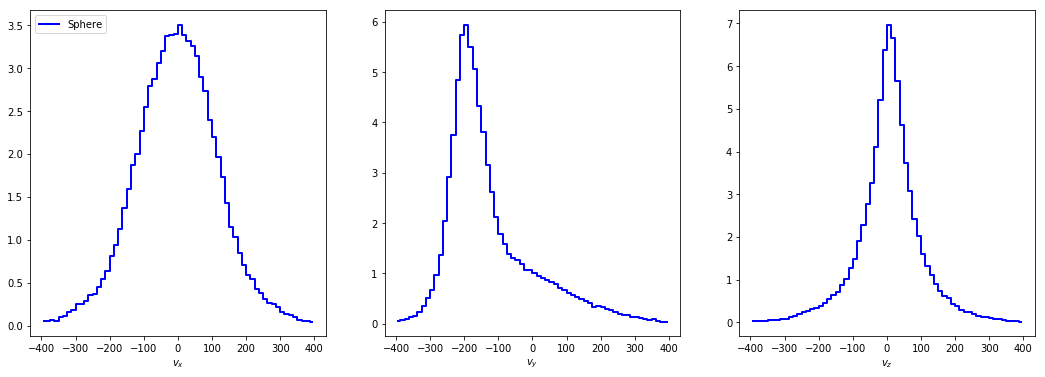

In [82]:
(x, y, z), (vx, vy, vz), rxyz, rxy = get_cartesian_vectors(s, sf, isolarsphere)

fig, (ax1, ax2, ax3) = pyplot.subplots(1, 3, figsize=(18, 6))

nbins = 64
range = (-400, +400)

bins, edges = numpy.histogram(vx, bins=nbins, range=range, normed=True)
ax1.plot((edges[:-1] + edges[1:])/2, 1000*bins, ls="steps-mid",
         lw=2, c="b", label="Sphere")
ax1.legend(loc="upper left")
ax1.set_xlabel(r"$v_x$")

bins, edges = numpy.histogram(vy, bins=nbins, range=range, normed=True)
ax2.plot((edges[:-1] + edges[1:])/2, 1000*bins, ls="steps-mid", 
         lw=2, c="b", label="Sphere")
ax2.set_xlabel(r"$v_y$")

bins, edges = numpy.histogram(vz, bins=nbins, range=range, normed=True)
ax3.plot((edges[:-1] + edges[1:])/2, 1000*bins, ls="steps-mid",
         lw=2, c="b", label="Sphere")
ax3.set_xlabel(r"$v_z$")

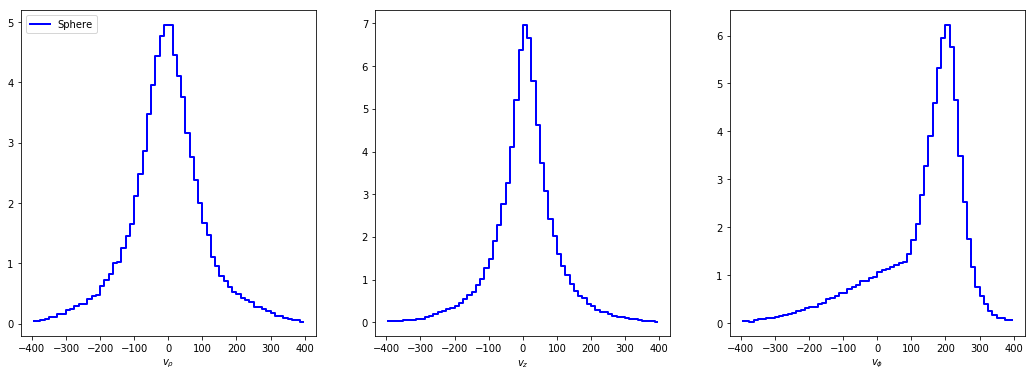

In [83]:
v_rho_local, v_z_local, v_phi_local = convert_cartesian_vel_to_cylindrical(s, sf, isolarsphere)

fig, (ax1, ax2, ax3) = pyplot.subplots(1, 3, figsize=(18, 6))

nbins = 64
range = (-400, +400)

bins, edges = numpy.histogram(v_rho_local, bins=nbins, range=range, normed=True)
ax1.plot((edges[:-1] + edges[1:])/2, 1000*bins, ls="steps-mid",
         lw=2, c="b", label="Sphere")
ax1.legend(loc="upper left")
ax1.set_xlabel(r"$v_\rho$")

bins, edges = numpy.histogram(v_z_local, bins=nbins, range=range, normed=True)
ax2.plot((edges[:-1] + edges[1:])/2, 1000*bins, ls="steps-mid", 
         lw=2, c="b", label="Sphere")
ax2.set_xlabel(r"$v_z$")

bins, edges = numpy.histogram(v_phi_local, bins=nbins, range=range, normed=True)
ax3.plot((edges[:-1] + edges[1:])/2, 1000*bins, ls="steps-mid",
         lw=2, c="b", label="Sphere")
ax3.set_xlabel(r"$v_\phi$")

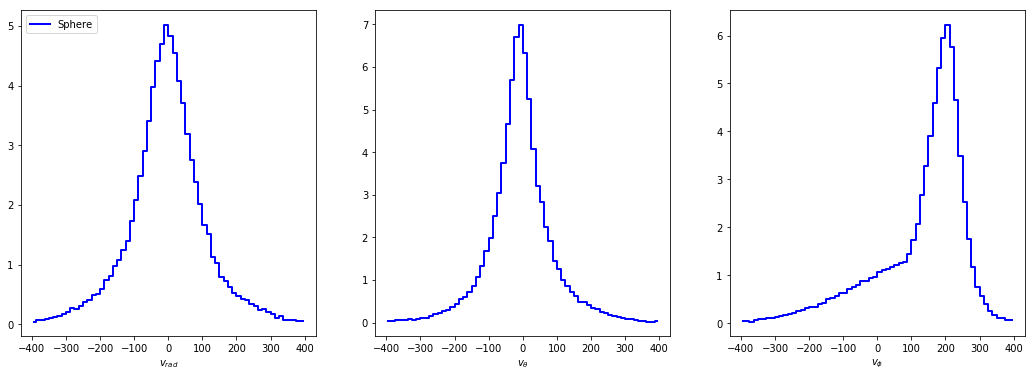

In [84]:
v_rad, v_theta, v_phi = convert_cartesian_vel_to_spherical(s, sf, isolarsphere)

fig, (ax1, ax2, ax3) = pyplot.subplots(1, 3, figsize=(18, 6))

nbins = 64
range = (-400, +400)

bins, edges = numpy.histogram(v_rad, bins=nbins, range=range, normed=True)
ax1.plot((edges[:-1] + edges[1:])/2, 1000*bins, ls="steps-mid",
         lw=2, c="b", label="Sphere")
ax1.legend(loc="upper left")
ax1.set_xlabel(r"$v_{rad}$")

bins, edges = numpy.histogram(v_theta, bins=nbins, range=range, normed=True)
ax2.plot((edges[:-1] + edges[1:])/2, 1000*bins, ls="steps-mid", 
         lw=2, c="b", label="Sphere")
ax2.set_xlabel(r"$v_{\theta}$")

bins, edges = numpy.histogram(v_phi, bins=nbins, range=range, normed=True)
ax3.plot((edges[:-1] + edges[1:])/2, 1000*bins, ls="steps-mid",
         lw=2, c="b", label="Sphere")
ax3.set_xlabel(r"$v_{\phi}$")

## Dark Matter within Solar Sphere

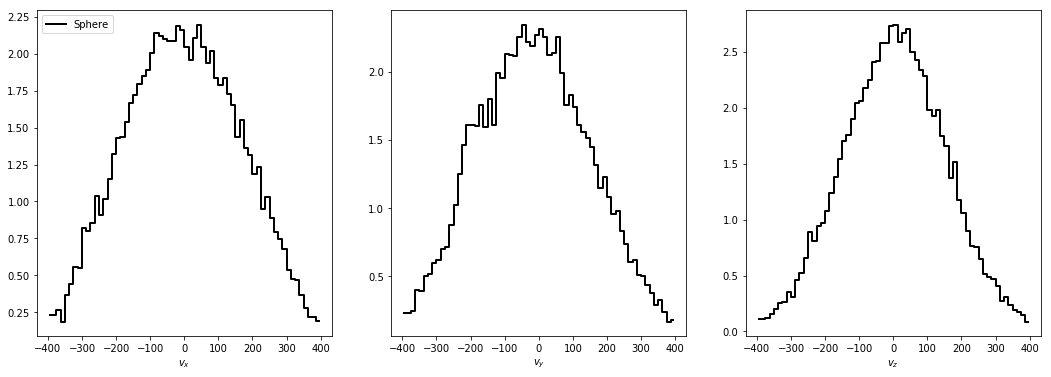

In [88]:
(x, y, z), (vx, vy, vz), rxyz, rxy = get_cartesian_vectors(s, sf, isolarsphere_dm)

fig, (ax1, ax2, ax3) = pyplot.subplots(1, 3, figsize=(18, 6))

nbins = 64
range = (-400, +400)

bins, edges = numpy.histogram(vx, bins=nbins, range=range, normed=True)
ax1.plot((edges[:-1] + edges[1:])/2, 1000*bins, ls="steps-mid",
         lw=2, c="k", label="Sphere")
ax1.legend(loc="upper left")
ax1.set_xlabel(r"$v_x$")

bins, edges = numpy.histogram(vy, bins=nbins, range=range, normed=True)
ax2.plot((edges[:-1] + edges[1:])/2, 1000*bins, ls="steps-mid", 
         lw=2, c="k", label="Sphere")
ax2.set_xlabel(r"$v_y$")

bins, edges = numpy.histogram(vz, bins=nbins, range=range, normed=True)
ax3.plot((edges[:-1] + edges[1:])/2, 1000*bins, ls="steps-mid",
         lw=2, c="k", label="Sphere")
ax3.set_xlabel(r"$v_z$")

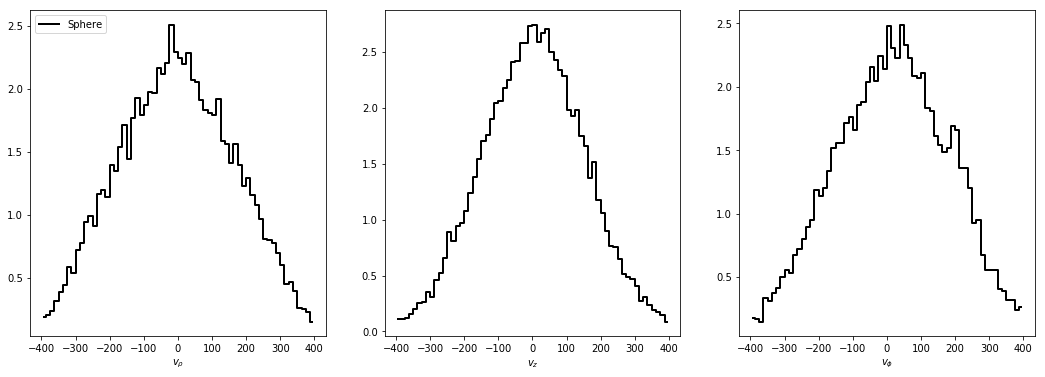

In [89]:
v_rho_local, v_z_local, v_phi_local = convert_cartesian_vel_to_cylindrical(s, sf, isolarsphere_dm)

fig, (ax1, ax2, ax3) = pyplot.subplots(1, 3, figsize=(18, 6))

nbins = 64
range = (-400, +400)

bins, edges = numpy.histogram(v_rho_local, bins=nbins, range=range, normed=True)
ax1.plot((edges[:-1] + edges[1:])/2, 1000*bins, ls="steps-mid",
         lw=2, c="k", label="Sphere")
ax1.legend(loc="upper left")
ax1.set_xlabel(r"$v_\rho$")

bins, edges = numpy.histogram(v_z_local, bins=nbins, range=range, normed=True)
ax2.plot((edges[:-1] + edges[1:])/2, 1000*bins, ls="steps-mid", 
         lw=2, c="k", label="Sphere")
ax2.set_xlabel(r"$v_z$")

bins, edges = numpy.histogram(v_phi_local, bins=nbins, range=range, normed=True)
ax3.plot((edges[:-1] + edges[1:])/2, 1000*bins, ls="steps-mid",
         lw=2, c="k", label="Sphere")
ax3.set_xlabel(r"$v_\phi$")

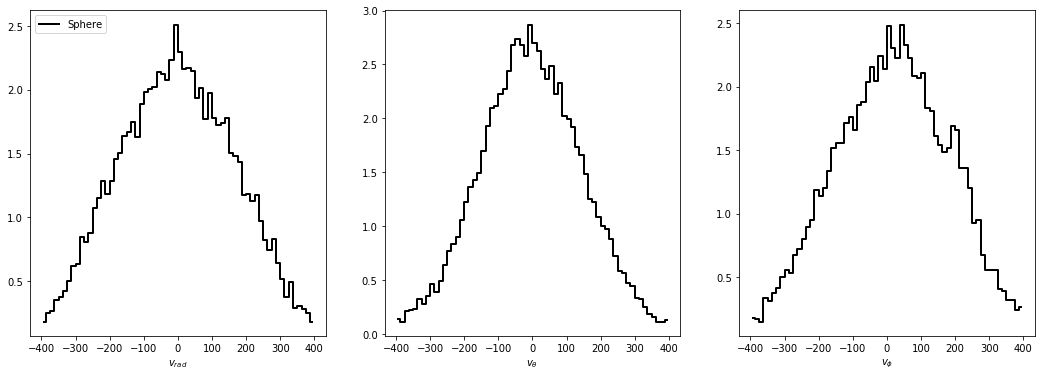

In [90]:
v_rad, v_theta, v_phi = convert_cartesian_vel_to_spherical(s, sf, isolarsphere_dm)

fig, (ax1, ax2, ax3) = pyplot.subplots(1, 3, figsize=(18, 6))

nbins = 64
range = (-400, +400)

bins, edges = numpy.histogram(v_rad, bins=nbins, range=range, normed=True)
ax1.plot((edges[:-1] + edges[1:])/2, 1000*bins, ls="steps-mid",
         lw=2, c="k", label="Sphere")
ax1.legend(loc="upper left")
ax1.set_xlabel(r"$v_{rad}$")

bins, edges = numpy.histogram(v_theta, bins=nbins, range=range, normed=True)
ax2.plot((edges[:-1] + edges[1:])/2, 1000*bins, ls="steps-mid", 
         lw=2, c="k", label="Sphere")
ax2.set_xlabel(r"$v_{\theta}$")

bins, edges = numpy.histogram(v_phi, bins=nbins, range=range, normed=True)
ax3.plot((edges[:-1] + edges[1:])/2, 1000*bins, ls="steps-mid",
         lw=2, c="k", label="Sphere")
ax3.set_xlabel(r"$v_{\phi}$")

## Stars within Solar Sphere with [Fe/H] < -1; [Fe/H] < -2

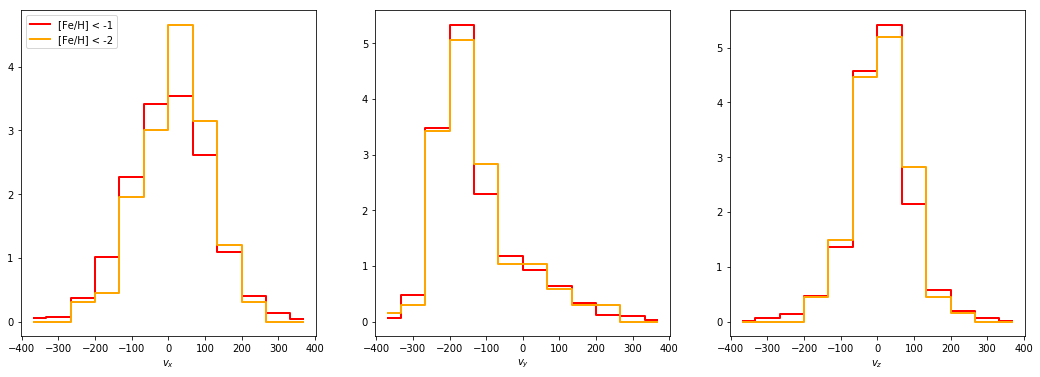

In [94]:
(x, y, z), (vx, vy, vz), rxyz, rxy = get_cartesian_vectors(s, sf, isolarsphere)

fig, (ax1, ax2, ax3) = pyplot.subplots(1, 3, figsize=(18, 6))

nbins = 12
range = (-400, +400)

bins, edges = numpy.histogram(vx[metalcut1], bins=nbins, range=range, normed=True)
ax1.plot((edges[:-1] + edges[1:])/2, 1000*bins, ls="steps-mid",
         lw=2, c="r", label="[Fe/H] < -1")
bins, edges = numpy.histogram(vx[metalcut2], bins=nbins, range=range, normed=True)
ax1.plot((edges[:-1] + edges[1:])/2, 1000*bins, ls="steps-mid",
         lw=2, c="orange", label="[Fe/H] < -2")
ax1.legend(loc="upper left")
ax1.set_xlabel(r"$v_x$")

bins, edges = numpy.histogram(vy[metalcut1], bins=nbins, range=range, normed=True)
ax2.plot((edges[:-1] + edges[1:])/2, 1000*bins, ls="steps-mid", 
         lw=2, c="r", label="[Fe/H] < -1")
bins, edges = numpy.histogram(vy[metalcut2], bins=nbins, range=range, normed=True)
ax2.plot((edges[:-1] + edges[1:])/2, 1000*bins, ls="steps-mid", 
         lw=2, c="orange", label="[Fe/H] < -2")
ax2.set_xlabel(r"$v_y$")

bins, edges = numpy.histogram(vz[metalcut1], bins=nbins, range=range, normed=True)
ax3.plot((edges[:-1] + edges[1:])/2, 1000*bins, ls="steps-mid",
         lw=2, c="r", label="[Fe/H] < -1")
bins, edges = numpy.histogram(vz[metalcut2], bins=nbins, range=range, normed=True)
ax3.plot((edges[:-1] + edges[1:])/2, 1000*bins, ls="steps-mid",
         lw=2, c="orange", label="[Fe/H] < -2")
ax3.set_xlabel(r"$v_z$")

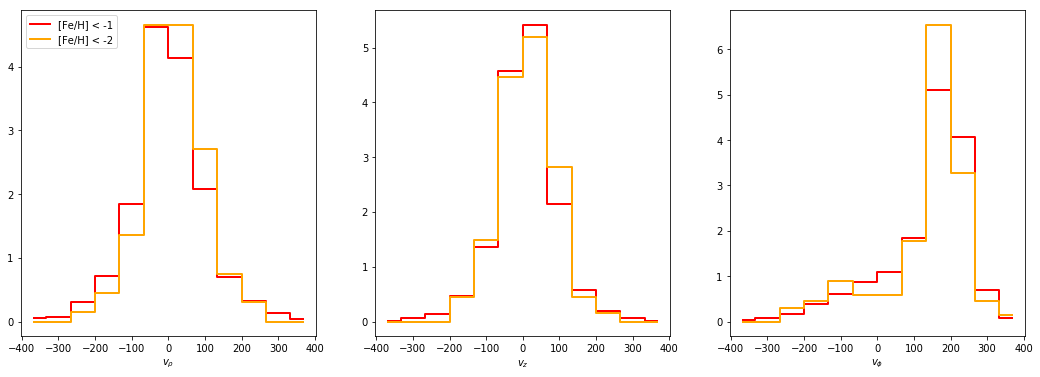

In [95]:
v_rho_local, v_z_local, v_phi_local = convert_cartesian_vel_to_cylindrical(s, sf, isolarsphere)

fig, (ax1, ax2, ax3) = pyplot.subplots(1, 3, figsize=(18, 6))

nbins = 12
range = (-400, +400)

bins, edges = numpy.histogram(v_rho_local[metalcut1], bins=nbins, range=range, normed=True)
ax1.plot((edges[:-1] + edges[1:])/2, 1000*bins, ls="steps-mid",
         lw=2, c="r", label="[Fe/H] < -1")
bins, edges = numpy.histogram(v_rho_local[metalcut2], bins=nbins, range=range, normed=True)
ax1.plot((edges[:-1] + edges[1:])/2, 1000*bins, ls="steps-mid",
         lw=2, c="orange", label="[Fe/H] < -2")
ax1.legend(loc="upper left")
ax1.set_xlabel(r"$v_\rho$")

bins, edges = numpy.histogram(v_z_local[metalcut1], bins=nbins, range=range, normed=True)
ax2.plot((edges[:-1] + edges[1:])/2, 1000*bins, ls="steps-mid", 
         lw=2, c="r", label="[Fe/H] < -1")
bins, edges = numpy.histogram(v_z_local[metalcut2], bins=nbins, range=range, normed=True)
ax2.plot((edges[:-1] + edges[1:])/2, 1000*bins, ls="steps-mid", 
         lw=2, c="orange", label="[Fe/H] < -2")
ax2.set_xlabel(r"$v_z$")

bins, edges = numpy.histogram(v_phi_local[metalcut1], bins=nbins, range=range, normed=True)
ax3.plot((edges[:-1] + edges[1:])/2, 1000*bins, ls="steps-mid",
         lw=2, c="r", label="[Fe/H] < -1")
bins, edges = numpy.histogram(v_phi_local[metalcut2], bins=nbins, range=range, normed=True)
ax3.plot((edges[:-1] + edges[1:])/2, 1000*bins, ls="steps-mid",
         lw=2, c="orange", label="[Fe/H] < -2")
ax3.set_xlabel(r"$v_\phi$")

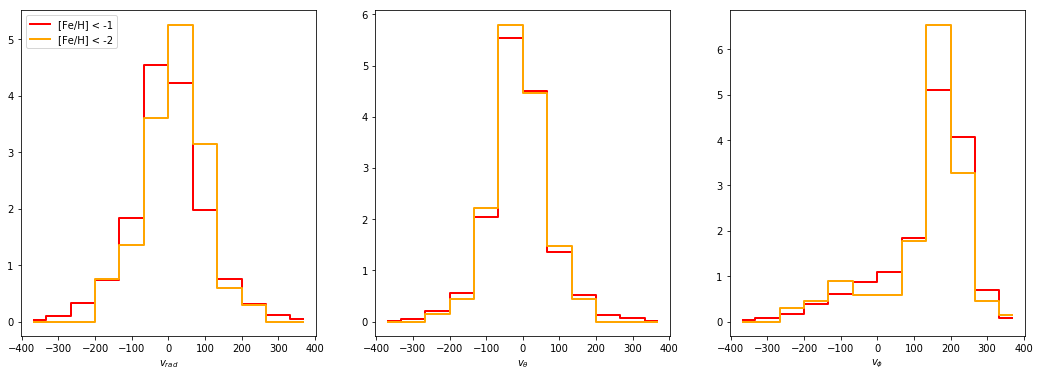

In [98]:
v_rad, v_theta, v_phi = convert_cartesian_vel_to_spherical(s, sf, isolarsphere)

fig, (ax1, ax2, ax3) = pyplot.subplots(1, 3, figsize=(18, 6))

nbins = 12
range = (-400, +400)

bins, edges = numpy.histogram(v_rad[metalcut1], bins=nbins, range=range, normed=True)
ax1.plot((edges[:-1] + edges[1:])/2, 1000*bins, ls="steps-mid",
         lw=2, c="r", label="[Fe/H] < -1")
bins, edges = numpy.histogram(v_rad[metalcut2], bins=nbins, range=range, normed=True)
ax1.plot((edges[:-1] + edges[1:])/2, 1000*bins, ls="steps-mid",
         lw=2, c="orange", label="[Fe/H] < -2")
ax1.legend(loc="upper left")
ax1.set_xlabel(r"$v_{rad}$")

bins, edges = numpy.histogram(v_theta[metalcut1], bins=nbins, range=range, normed=True)
ax2.plot((edges[:-1] + edges[1:])/2, 1000*bins, ls="steps-mid", 
         lw=2, c="r", label="[Fe/H] < -1")
bins, edges = numpy.histogram(v_theta[metalcut2], bins=nbins, range=range, normed=True)
ax2.plot((edges[:-1] + edges[1:])/2, 1000*bins, ls="steps-mid", 
         lw=2, c="orange", label="[Fe/H] < -2")
ax2.set_xlabel(r"$v_\theta$")

bins, edges = numpy.histogram(v_phi[metalcut1], bins=nbins, range=range, normed=True)
ax3.plot((edges[:-1] + edges[1:])/2, 1000*bins, ls="steps-mid",
         lw=2, c="r", label="[Fe/H] < -1")
bins, edges = numpy.histogram(v_phi[metalcut2], bins=nbins, range=range, normed=True)
ax3.plot((edges[:-1] + edges[1:])/2, 1000*bins, ls="steps-mid",
         lw=2, c="orange", label="[Fe/H] < -2")
ax3.set_xlabel(r"$v_\phi$")

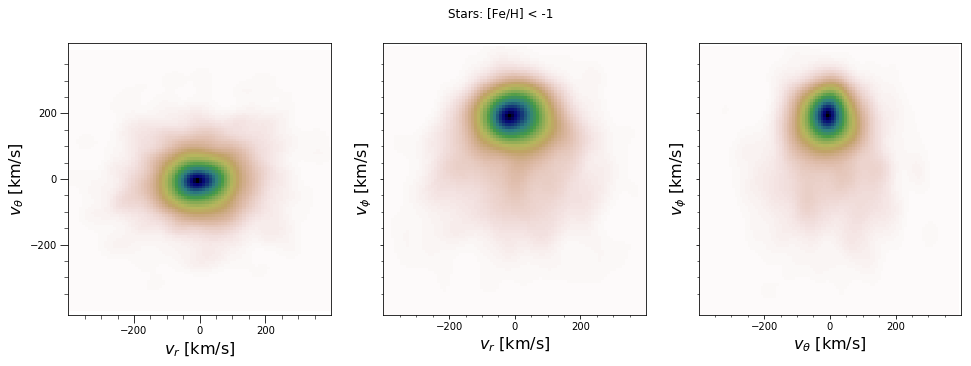

In [144]:
from scipy.stats import gaussian_kde

v_rad, v_theta, v_phi = convert_cartesian_vel_to_spherical(s, sf, isolarsphere)

# Plot in the same style as the paper.
fig, (ax1, ax2, ax3) = pyplot.subplots(1, 3,
    sharey=True, sharex=True, figsize=(16, 5))

fig.suptitle("Stars: [Fe/H] < -1")

ax1.set_xlim(-400, 400)
ax1.set_ylim(-400, 400)
ax1.set_xticks([-200, 0, 200])
ax1.set_yticks([-200, 0, 200])
ax1.minorticks_on()
ax1.tick_params(length=8, which="major")
ax1.tick_params(length=4, which="minor")

fontsize=16
# ax1.plot(v_rad[metalcut1], v_theta[metalcut1], c="r", marker="o", ls="", ms=1, alpha=0.2)
# KDE
xmin, xmax = v_rad[metalcut1].min(), v_rad[metalcut1].max()
ymin, ymax = v_theta[metalcut1].min(), v_theta[metalcut1].max()
X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = numpy.vstack([X.ravel(), Y.ravel()])
values = numpy.vstack([v_rad[metalcut1], v_theta[metalcut1]])
kernel = gaussian_kde(values)
Z = numpy.reshape(kernel(positions).T, X.shape)
ax1.imshow(numpy.rot90(Z), cmap=pyplot.cm.gist_earth_r,
          extent=[xmin, xmax, ymin, ymax])
ax1.set_xlabel(r"$v_r$ [km/s]", fontsize=fontsize)
ax1.set_ylabel(r"$v_\theta$ [km/s]", fontsize=fontsize)

# ax2.plot(v_rad[metalcut1], v_phi[metalcut1], c="r", marker="o", ls="", ms=1, alpha=0.2)
#KDE 
xmin, xmax = v_rad[metalcut1].min(), v_rad[metalcut1].max()
ymin, ymax = v_phi[metalcut1].min(), v_phi[metalcut1].max()
X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = numpy.vstack([X.ravel(), Y.ravel()])
values = numpy.vstack([v_rad[metalcut1], v_phi[metalcut1]])
kernel = gaussian_kde(values)
Z = numpy.reshape(kernel(positions).T, X.shape)
ax2.imshow(numpy.rot90(Z), cmap=pyplot.cm.gist_earth_r,
          extent=[xmin, xmax, ymin, ymax])
ax2.set_xlabel(r"$v_r$ [km/s]", fontsize=fontsize)
ax2.set_ylabel(r"$v_\phi$ [km/s]", fontsize=fontsize)

# ax3.plot(v_theta[metalcut1], v_phi[metalcut1], c="r", marker="o", ls="", ms=1, alpha=0.2)
#KDE 
xmin, xmax = v_theta[metalcut1].min(), v_theta[metalcut1].max()
ymin, ymax = v_phi[metalcut1].min(), v_phi[metalcut1].max()
X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = numpy.vstack([X.ravel(), Y.ravel()])
values = numpy.vstack([v_theta[metalcut1], v_phi[metalcut1]])
kernel = gaussian_kde(values)
Z = numpy.reshape(kernel(positions).T, X.shape)
ax3.imshow(numpy.rot90(Z), cmap=pyplot.cm.gist_earth_r,
          extent=[xmin, xmax, ymin, ymax])
ax3.set_xlabel(r"$v_\theta$ [km/s]", fontsize=fontsize)
ax3.set_ylabel(r"$v_\phi$ [km/s]", fontsize=fontsize)

# pyplot.savefig("out/auriga_level"+
#     "{0}_halo{1}_snapnr{2}_spherical_velocities.pdf"\
#     .format(s.level, s.halo_number, s.snapnr))

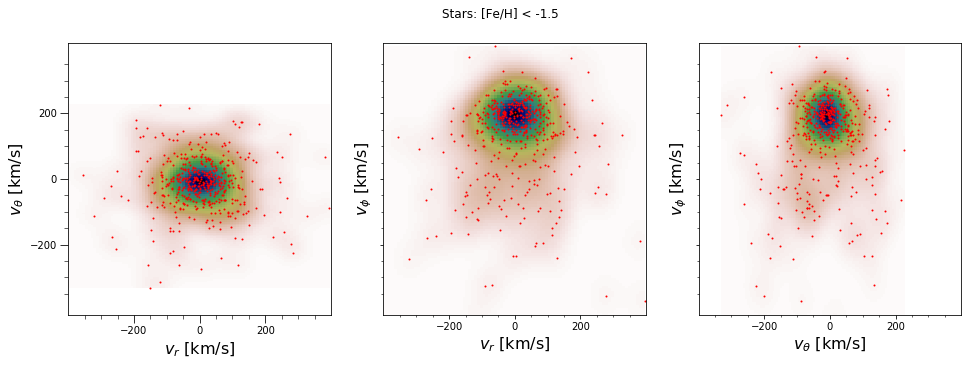

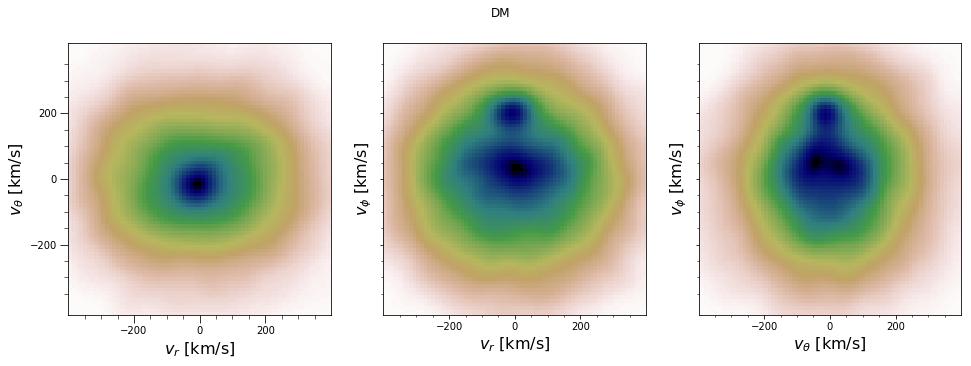

In [167]:
from scipy.stats import gaussian_kde

v_rad, v_theta, v_phi = convert_cartesian_vel_to_spherical(s, sf, isolarsphere)

# Plot in the same style as the paper.
fig, (ax1, ax2, ax3) = pyplot.subplots(1, 3,
    sharey=True, sharex=True, figsize=(16, 5))

fig.suptitle("Stars: [Fe/H] < -1.5")

ax1.set_xlim(-400, 400)
ax1.set_ylim(-400, 400)
ax1.set_xticks([-200, 0, 200])
ax1.set_yticks([-200, 0, 200])
ax1.minorticks_on()
ax1.tick_params(length=8, which="major")
ax1.tick_params(length=4, which="minor")

fontsize=16
ax1.plot(v_rad[metalcut15], v_theta[metalcut15], c="r", marker="o", ls="", ms=1)
# KDE
xmin, xmax = v_rad[metalcut15].min(), v_rad[metalcut15].max()
ymin, ymax = v_theta[metalcut15].min(), v_theta[metalcut15].max()
X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = numpy.vstack([X.ravel(), Y.ravel()])
values = numpy.vstack([v_rad[metalcut15], v_theta[metalcut15]])
kernel = gaussian_kde(values)
Z = numpy.reshape(kernel(positions).T, X.shape)
ax1.imshow(numpy.rot90(Z), cmap=pyplot.cm.gist_earth_r,
          extent=[xmin, xmax, ymin, ymax])
ax1.set_xlabel(r"$v_r$ [km/s]", fontsize=fontsize)
ax1.set_ylabel(r"$v_\theta$ [km/s]", fontsize=fontsize)

ax2.plot(v_rad[metalcut15], v_phi[metalcut15], c="r", marker="o", ls="", ms=1)
#KDE 
xmin, xmax = v_rad[metalcut15].min(), v_rad[metalcut15].max()
ymin, ymax = v_phi[metalcut15].min(), v_phi[metalcut15].max()
X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = numpy.vstack([X.ravel(), Y.ravel()])
values = numpy.vstack([v_rad[metalcut15], v_phi[metalcut15]])
kernel = gaussian_kde(values)
Z = numpy.reshape(kernel(positions).T, X.shape)
ax2.imshow(numpy.rot90(Z), cmap=pyplot.cm.gist_earth_r,
          extent=[xmin, xmax, ymin, ymax])
ax2.set_xlabel(r"$v_r$ [km/s]", fontsize=fontsize)
ax2.set_ylabel(r"$v_\phi$ [km/s]", fontsize=fontsize)

ax3.plot(v_theta[metalcut15], v_phi[metalcut15], c="r", marker="o", ls="", ms=1)
#KDE 
xmin, xmax = v_theta[metalcut15].min(), v_theta[metalcut15].max()
ymin, ymax = v_phi[metalcut15].min(), v_phi[metalcut15].max()
X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = numpy.vstack([X.ravel(), Y.ravel()])
values = numpy.vstack([v_theta[metalcut15], v_phi[metalcut15]])
kernel = gaussian_kde(values)
Z = numpy.reshape(kernel(positions).T, X.shape)
ax3.imshow(numpy.rot90(Z), cmap=pyplot.cm.gist_earth_r,
          extent=[xmin, xmax, ymin, ymax])
ax3.set_xlabel(r"$v_\theta$ [km/s]", fontsize=fontsize)
ax3.set_ylabel(r"$v_\phi$ [km/s]", fontsize=fontsize)

# pyplot.savefig("out/auriga_level"+
#     "{0}_halo{1}_snapnr{2}_spherical_velocities.pdf"\
#     .format(s.level, s.halo_number, s.snapnr))





## DARK MATTER
v_rad, v_theta, v_phi = convert_cartesian_vel_to_spherical(s, sf, isolarsphere_dm)

# Plot in the same style as the paper.
fig, (ax1, ax2, ax3) = pyplot.subplots(1, 3,
    sharey=True, sharex=True, figsize=(16, 5))

fig.suptitle("DM")

ax1.set_xlim(-400, 400)
ax1.set_ylim(-400, 400)
ax1.set_xticks([-200, 0, 200])
ax1.set_yticks([-200, 0, 200])
ax1.minorticks_on()
ax1.tick_params(length=8, which="major")
ax1.tick_params(length=4, which="minor")

fontsize=16
# ax1.plot(v_rad, v_theta, c="k", marker="o", ls="", ms=1, alpha=0.2)
# KDE
xmin, xmax = v_rad.min(), v_rad.max()
ymin, ymax = v_theta.min(), v_theta.max()
X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = numpy.vstack([X.ravel(), Y.ravel()])
values = numpy.vstack([v_rad, v_theta])
kernel = gaussian_kde(values)
Z = numpy.reshape(kernel(positions).T, X.shape)
ax1.imshow(numpy.rot90(Z), cmap=pyplot.cm.gist_earth_r,
          extent=[xmin, xmax, ymin, ymax])
ax1.set_xlabel(r"$v_r$ [km/s]", fontsize=fontsize)
ax1.set_ylabel(r"$v_\theta$ [km/s]", fontsize=fontsize)

# ax2.plot(v_rad, v_phi, c="k", marker="o", ls="", ms=1, alpha=0.2)
#KDE 
xmin, xmax = v_rad.min(), v_rad.max()
ymin, ymax = v_phi.min(), v_phi.max()
X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = numpy.vstack([X.ravel(), Y.ravel()])
values = numpy.vstack([v_rad, v_phi])
kernel = gaussian_kde(values)
Z = numpy.reshape(kernel(positions).T, X.shape)
ax2.imshow(numpy.rot90(Z), cmap=pyplot.cm.gist_earth_r,
          extent=[xmin, xmax, ymin, ymax])
ax2.set_xlabel(r"$v_r$ [km/s]", fontsize=fontsize)
ax2.set_ylabel(r"$v_\phi$ [km/s]", fontsize=fontsize)

# ax3.plot(v_theta, v_phi, c="k", marker="o", ls="", ms=1, alpha=0.2)
#KDE 
xmin, xmax = v_theta.min(), v_theta.max()
ymin, ymax = v_phi.min(), v_phi.max()
X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = numpy.vstack([X.ravel(), Y.ravel()])
values = numpy.vstack([v_theta, v_phi])
kernel = gaussian_kde(values)
Z = numpy.reshape(kernel(positions).T, X.shape)
ax3.imshow(numpy.rot90(Z), cmap=pyplot.cm.gist_earth_r,
          extent=[xmin, xmax, ymin, ymax])
ax3.set_xlabel(r"$v_\theta$ [km/s]", fontsize=fontsize)
ax3.set_ylabel(r"$v_\phi$ [km/s]", fontsize=fontsize)

# pyplot.savefig("out/auriga_level"+
#     "{0}_halo{1}_snapnr{2}_spherical_velocities.pdf"\
#     .format(s.level, s.halo_number, s.snapnr))

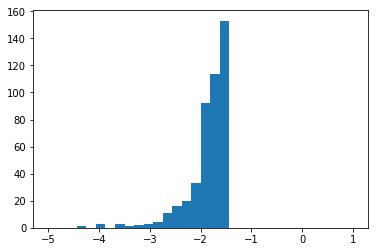

In [157]:
pyplot.figure()
h = pyplot.hist(feabund[metalcut15], range=(-5, 1), bins=32)

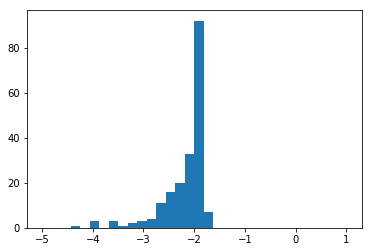

In [158]:
pyplot.figure()
h = pyplot.hist(feabund[metalcut18], range=(-5, 1), bins=32)

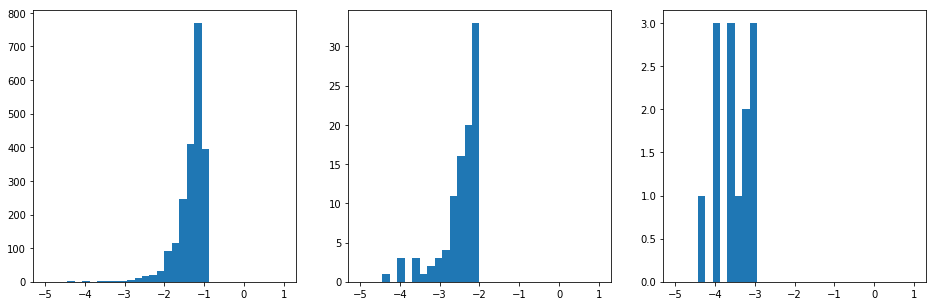

In [160]:
fig, (ax1, ax2, ax3) = pyplot.subplots(1, 3, figsize=(16, 5))
h = ax1.hist(feabund[metalcut1], range=(-5, 1), bins=32)
h = ax2.hist(feabund[metalcut2], range=(-5, 1), bins=32)
h = ax3.hist(feabund[metalcut3], range=(-5, 1), bins=32)

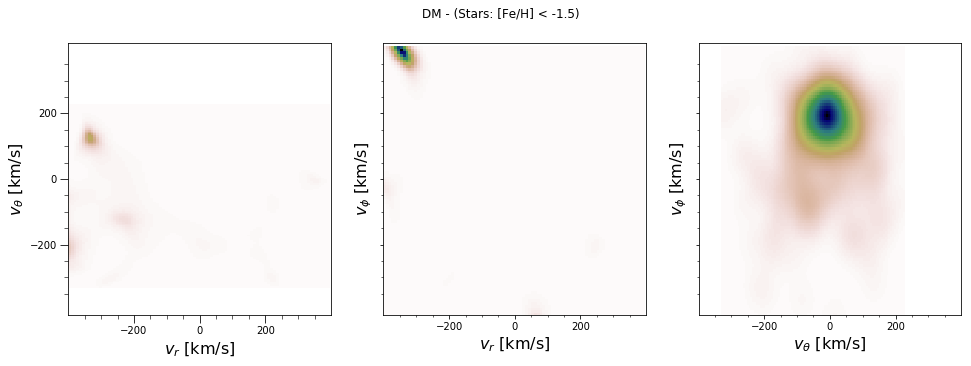

In [166]:
v_rad, v_theta, v_phi = convert_cartesian_vel_to_spherical(s, sf, isolarsphere)
v_rad_dm, v_theta_dm, v_phi_dm = convert_cartesian_vel_to_spherical(s, sf, isolarsphere_dm)

# Plot in the same style as the paper.
fig, (ax1, ax2, ax3) = pyplot.subplots(1, 3,
    sharey=True, sharex=True, figsize=(16, 5))

fig.suptitle("DM - (Stars: [Fe/H] < -1.5)")

ax1.set_xlim(-400, 400)
ax1.set_ylim(-400, 400)
ax1.set_xticks([-200, 0, 200])
ax1.set_yticks([-200, 0, 200])
ax1.minorticks_on()
ax1.tick_params(length=8, which="major")
ax1.tick_params(length=4, which="minor")

fontsize=16
# ax1.plot(v_rad, v_theta, c="k", marker="o", ls="", ms=1, alpha=0.2)
# KDE
# dm
xmin, xmax = v_rad_dm.min(), v_rad_dm.max()
ymin, ymax = v_theta_dm.min(), v_theta_dm.max()
X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = numpy.vstack([X.ravel(), Y.ravel()])
values = numpy.vstack([v_rad_dm, v_theta_dm])
kernel = gaussian_kde(values)
Z_dm = numpy.reshape(kernel(positions).T, X.shape)
# stars
xmin, xmax = v_rad[metalcut15].min(), v_rad[metalcut15].max()
ymin, ymax = v_theta[metalcut15].min(), v_theta[metalcut15].max()
X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = numpy.vstack([X.ravel(), Y.ravel()])
values = numpy.vstack([v_rad[metalcut15], v_theta[metalcut15]])
kernel = gaussian_kde(values)
Z = numpy.reshape(kernel(positions).T, X.shape)

ax1.imshow(numpy.rot90((Z_dm - Z)/Z), cmap=pyplot.cm.gist_earth_r,
          extent=[xmin, xmax, ymin, ymax])
ax1.set_xlabel(r"$v_r$ [km/s]", fontsize=fontsize)
ax1.set_ylabel(r"$v_\theta$ [km/s]", fontsize=fontsize)

# ax2.plot(v_rad, v_phi, c="k", marker="o", ls="", ms=1, alpha=0.2)
# KDE 
# dm
xmin, xmax = v_rad_dm.min(), v_rad_dm.max()
ymin, ymax = v_phi_dm.min(), v_phi_dm.max()
X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = numpy.vstack([X.ravel(), Y.ravel()])
values = numpy.vstack([v_rad_dm, v_phi_dm])
kernel = gaussian_kde(values)
Z_dm = numpy.reshape(kernel(positions).T, X.shape)
# stars
xmin, xmax = v_rad[metalcut15].min(), v_rad[metalcut15].max()
ymin, ymax = v_phi[metalcut15].min(), v_phi[metalcut15].max()
X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = numpy.vstack([X.ravel(), Y.ravel()])
values = numpy.vstack([v_rad[metalcut15], v_phi[metalcut15]])
kernel = gaussian_kde(values)
Z = numpy.reshape(kernel(positions).T, X.shape)
ax2.imshow(numpy.rot90((Z_dm - Z)/Z), cmap=pyplot.cm.gist_earth_r,
          extent=[xmin, xmax, ymin, ymax])
ax2.set_xlabel(r"$v_r$ [km/s]", fontsize=fontsize)
ax2.set_ylabel(r"$v_\phi$ [km/s]", fontsize=fontsize)

# ax3.plot(v_theta, v_phi, c="k", marker="o", ls="", ms=1, alpha=0.2)
# KDE 
# dm
xmin, xmax = v_theta_dm.min(), v_theta_dm.max()
ymin, ymax = v_phi_dm.min(), v_phi_dm.max()
X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = numpy.vstack([X.ravel(), Y.ravel()])
values = numpy.vstack([v_theta_dm, v_phi_dm])
kernel = gaussian_kde(values)
Z_dm = numpy.reshape(kernel(positions).T, X.shape)
# stars
xmin, xmax = v_theta[metalcut15].min(), v_theta[metalcut15].max()
ymin, ymax = v_phi[metalcut15].min(), v_phi[metalcut15].max()
X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = numpy.vstack([X.ravel(), Y.ravel()])
values = numpy.vstack([v_theta[metalcut15], v_phi[metalcut15]])
kernel = gaussian_kde(values)
Z = numpy.reshape(kernel(positions).T, X.shape)
ax3.imshow((numpy.rot90(Z_dm) - numpy.rot90(Z)/numpy.rot90(Z)), cmap=pyplot.cm.gist_earth_r,
          extent=[xmin, xmax, ymin, ymax])
ax3.imshow(numpy.rot90(Z), cmap=pyplot.cm.gist_earth_r,
          extent=[xmin, xmax, ymin, ymax])
ax3.set_xlabel(r"$v_\theta$ [km/s]", fontsize=fontsize)
ax3.set_ylabel(r"$v_\phi$ [km/s]", fontsize=fontsize)

# pyplot.savefig("out/auriga_level"+
#     "{0}_halo{1}_snapnr{2}_spherical_velocities.pdf"\
#     .format(s.level, s.halo_number, s.snapnr))

to look at streams: plot in energy-angular momentum space

smaller region! to strong gradient towards Sun: not Solar neighbourhood!

compute first order moments, average and dispersion


dispersion population jeans equation radial profile


gc 1e5 Msun stars. star formation in Auriga few times 1e4 so star particles should have enough resolution
trace interesting star particles back in time, see where they come from.

we know orbits so we can calculate the tidal forces to figure out if a GC at that orbit would have stayed together

low star formation threshold in Auriga. GC below resolution limit. maybe simulation does not get high enough densities before starting to form stars because of the relatively low threshold.

if Auriga reasonable represention of MW, then should have GC